In [1]:
!hostname

gnode010.cluster


In [2]:
!nvidia-smi

Tue Apr 18 16:04:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:98:00.0 Off |                    0 |
| N/A   32C    P0    64W / 300W |      0MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import itertools as it
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sdeint
from toolbox import (
    make_loss,
    StatLoss,
    SINN,
    FPU
)

In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device('cuda')

In [6]:
print(torch.__version__)
print(torch.version.cuda)

1.13.0+cu117
11.7


200.0
(1000, 400) (1000, 400)
CPU times: user 1.11 s, sys: 1.98 ms, total: 1.11 s
Wall time: 1.11 s


Text(0.5, 1.0, 'Velocity Solution of the anharmonic Langevin dynamics with $\\gamma=0.1$ and $\\beta=1$')

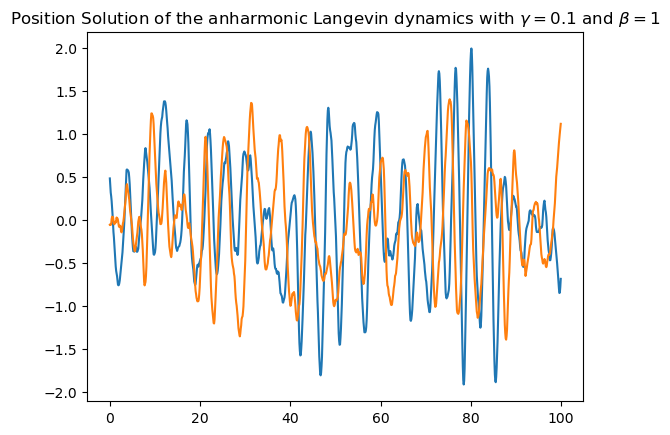

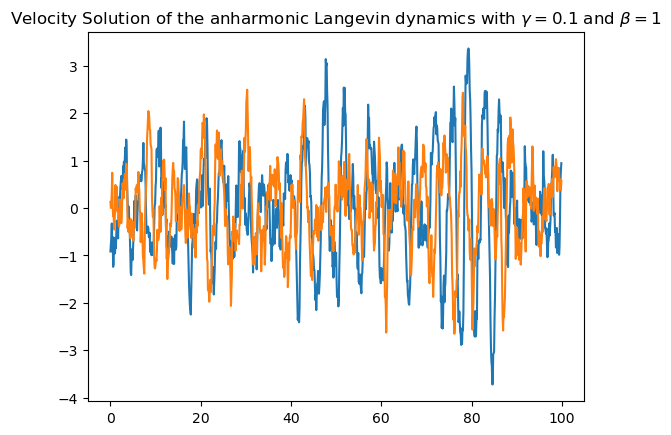

In [9]:
%%time

#### Generating SINN training data by solving SDE (Langevin dynamics)
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad


def V_FPU(x,U0,x0):
    v=U0/x0**4*x**3+U0/x0**2*x      # FPU potential 
    return v


#### Parameters 
gamma = 0.5                              # coupling constant 
beta = 1                               # Inverse temperature, i.e. T=1/beta
dt = 0.01                              # Step-size of the SDE solver 
delta_t = 0.1                          # Step-size of the temporally coarse-grained path
batch = 400                            # Batch size 
sec_length = 400                       # Length of the input sequence 
U0 = 1                                 # FPU parameter, depth of the well 
x0 = 1                                 # FPU parameter, position of the basin 

#### SDE solver (EM scheme) 
Time = 5*delta_t*sec_length
print(Time)
length=int(Time/dt)+1
t = np.linspace(0,Time,length) # define time axis
gap=int(delta_t/dt)
t_store=t[0:-1:gap]
p2_store = np.zeros([t_store.size+1,batch])
q2_store = np.zeros([t_store.size+1,batch])
# q_store = np.zeros([t_store.size+1,batch])
p2=np.zeros((2,batch))
q2=np.zeros((2,batch))

# solve SDE
j=1
for i in range(1,length):
     q2[1,:] = q2[0,:] + p2[0,:]*dt
     p2[1,:] = p2[0,:] + (-V_FPU(q2[0,:],U0,x0)-gamma*p2[0,:])*dt + np.random.randn(1,batch)*np.sqrt(2*dt*gamma/beta)
     if i % gap ==0:            
            p2_store[j,:]=p2[1,:]
            q2_store[j,:]=q2[1,:]
            j=j+1
     p2[0,:]=p2[1,:]
     q2[0,:]=q2[1,:]

Toss=int(t_store.size/2)
p2_store=p2_store[Toss:-1,:]          
q2_store=q2_store[Toss:-1,:]    
print(p2_store.shape,q2_store.shape)




plt.figure(0)
for i in range(2):
    plt.plot(t_store[Toss:]-t_store[Toss],q2_store[:,i])
# plt.legend()
plt.title(r"Position Solution of the anharmonic Langevin dynamics with $\gamma=0.1$ and $\beta=1$")
# plt.savefig("figs/FPU_dt016.pdf", dpi=150)

plt.figure(1)
for i in range(2):
    plt.plot(t_store[Toss:]-t_store[Toss],p2_store[:,i])
# plt.legend()
plt.title(r"Velocity Solution of the anharmonic Langevin dynamics with $\gamma=0.1$ and $\beta=1$")


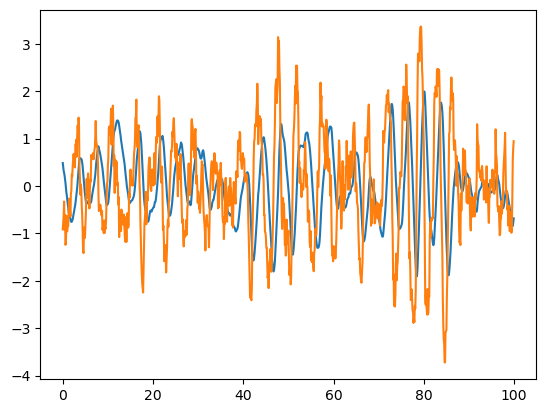

In [10]:
plt.plot(t_store[Toss:]-t_store[Toss],q2_store[:,0])
plt.plot(t_store[Toss:]-t_store[Toss],p2_store[:,0])

In [11]:
# Construct the sample traj for SINN learning 
ini=np.random.randn(sec_length,batch)
Traj_q=q2_store[0:sec_length,:]
Traj_p=p2_store[0:sec_length,:]
print(ini.shape, Traj_q.shape, Traj_p.shape)

Traj = np.empty((sec_length,batch,2))
Traj[:,:,0] = Traj_q
Traj[:,:,1] = Traj_p
T=np.arange(len(Traj_q[:,1]))*delta_t
x=np.linspace(-5,5,sec_length)
print(Traj.shape)

(400, 400) (400, 400) (400, 400)
(400, 400, 2)


# 1. 1 input

In [12]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 1)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 1), device=device)


Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 1]) torch.float32
The torch validation size is torch.Size([800, 400, 1]) torch.float32
The torch target size is torch.Size([400, 400, 2]) torch.float32


In [13]:
# Defining Loss functions
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_sec_moment = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_ccf_fft = make_loss('ccf[fft]', target, lags=LAGS, device=device)
loss_ccf_sec_moment = make_loss('ccf[fft]', target**2, lags=LAGS, device=device)
loss_ccf_bruteforce = make_loss('ccf[bruteforce]', target, lags=LAGS, device=device)
loss_ccf_randbrute = make_loss('ccf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_pdf_empirical = make_loss('pdf', target, lower=-5, upper=5, n=N, device=device)

torch.Size([400, 2])


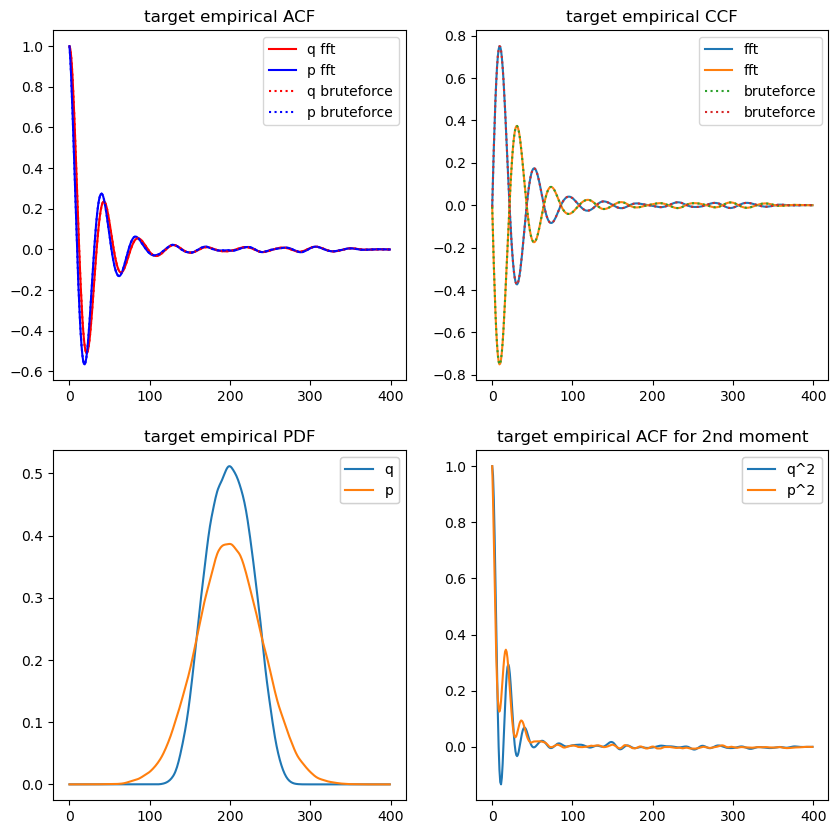

In [14]:
# Plotting target ACFs and PDF
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0,0].plot(loss_acf_fft._target.cpu()[...,0],'r', label='q fft')
axs[0,0].plot(loss_acf_fft._target.cpu()[...,-1],'b', label='p fft')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,0],'r:', label= 'q bruteforce')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,1], 'b:', label='p bruteforce')
axs[0,0].legend()
axs[0,0].set_title('target empirical ACF')

axs[0,1].plot(loss_ccf_fft._target.cpu()[...,1:3], label='fft')
axs[0,1].plot(loss_ccf_bruteforce._target.cpu()[...,1:3],':',label='bruteforce')
# legend2 = axs[0,1].legend(iter(bf), ('q bf', 'p bf'), loc=1)
# axs[0,1].add_artist(legend2)
axs[0,1].legend()
axs[0,1].set_title('target empirical CCF')

x_grid=-np.linspace(-5,5,num=sec_length)
pdf = axs[1,0].plot(loss_pdf_empirical._target.cpu())
legend3 = axs[1,0].legend(iter(pdf), ('q', 'p'), loc=1)
axs[1,0].add_artist(legend3)
axs[1,0].set_title('target empirical PDF')


print(loss_acf_sec_moment._target.cpu().size())
sec_moment = axs[1,1].plot(loss_acf_sec_moment._target.cpu())
legend4 = axs[1,1].legend(iter(sec_moment), ('q^2', 'p^2'),loc=1)
axs[1,1].set_title('target empirical ACF for 2nd moment')
axs[1,1].add_artist(legend4)

plt.show()

## 1.1. Loss function=ACF($\textbf{x}$)+PDF($\textbf{x}$)+ACF($\textbf{x}^2$)

In [15]:
### Defining SINN model
net = SINN(1, 5, 2, 2).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [16]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_acf_fft(prediction) + loss_pdf_empirical(prediction) + loss_acf_sec_moment(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_empirical(pred_val) + loss_acf_sec_moment(pred_val**2)
            loss_val_acf = loss_acf_bruteforce(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.0005 and loss_val<=0.0005:
            break
print('Training finished')

[0]-th step loss: 0.270, 0.270
[50]-th step loss: 0.242, 0.241
[100]-th step loss: 0.062, 0.061
[150]-th step loss: 0.036, 0.036
[200]-th step loss: 0.024, 0.023
[250]-th step loss: 0.015, 0.014
[300]-th step loss: 0.007, 0.007
[350]-th step loss: 0.004, 0.005
[400]-th step loss: 0.003, 0.003
[450]-th step loss: 0.003, 0.003
[500]-th step loss: 0.002, 0.002
[550]-th step loss: 0.002, 0.002
[600]-th step loss: 0.002, 0.002
[650]-th step loss: 0.002, 0.002
[700]-th step loss: 0.002, 0.002
[750]-th step loss: 0.001, 0.002
[800]-th step loss: 0.001, 0.001
[850]-th step loss: 0.001, 0.001
[900]-th step loss: 0.001, 0.001
[950]-th step loss: 0.001, 0.001
[1000]-th step loss: 0.001, 0.001
[1050]-th step loss: 0.001, 0.001
[1100]-th step loss: 0.001, 0.001
[1150]-th step loss: 0.001, 0.001
[1200]-th step loss: 0.001, 0.001
[1250]-th step loss: 0.001, 0.001
[1300]-th step loss: 0.001, 0.001
[1350]-th step loss: 0.001, 0.001
[1400]-th step loss: 0.001, 0.001
[1450]-th step loss: 0.001, 0.001
[15

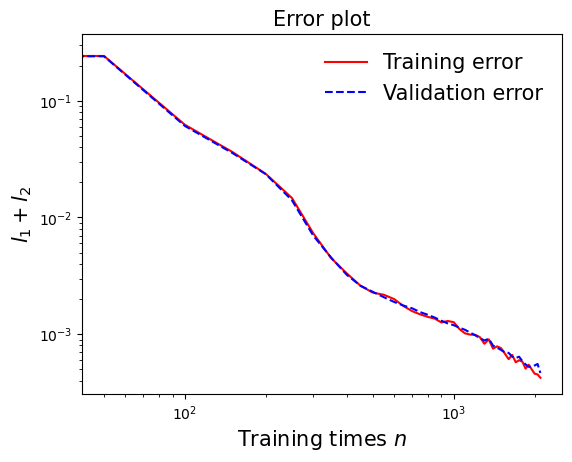

In [17]:
### ACF
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [18]:
# # Gaussian random input
ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
Pred,_= net(ran_input)
prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)

([<matplotlib.axis.YTick at 0x1457125f4af0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

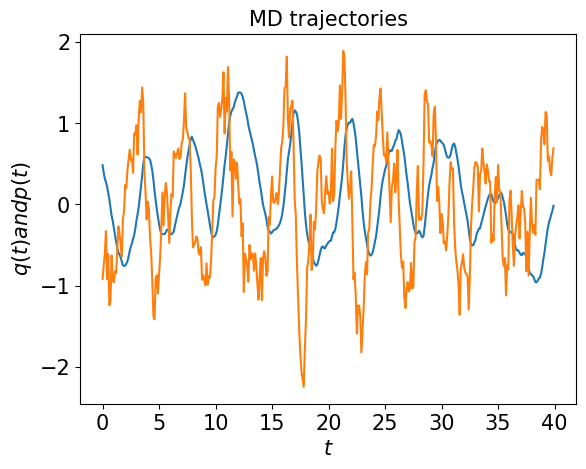

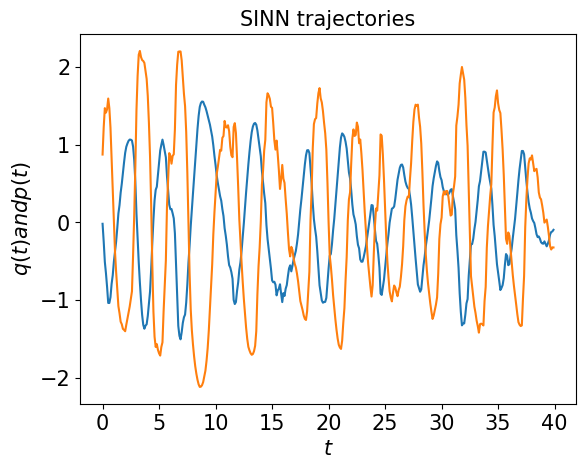

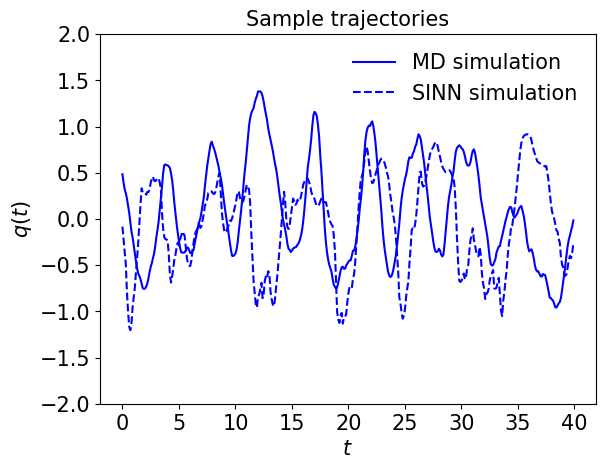

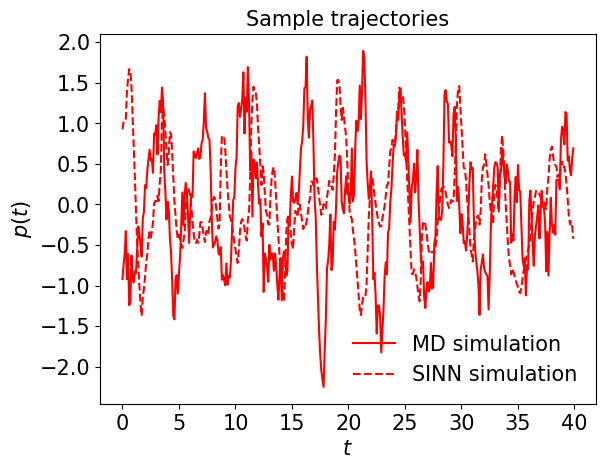

In [19]:
# Test 1: plot the sample path generated by SINN and the exact sample path 
skip = 0

fig = plt.figure(0)
plt.title("MD trajectories",fontsize=15) 
plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t) and p(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15) 
# plt.savefig("figs/FPU_traj_multi_MD.pdf", dpi=150)

fig = plt.figure(1)
plt.title("SINN trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t) and p(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/FPU_traj_multi.pdf", dpi=150)


fig = plt.figure(2)
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 0, 0],'b', label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 8, 0],'b--',label='SINN simulation')
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)

fig = plt.figure(3)
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 0, 1],'r', label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 8, 1],'r--',label='SINN simulation')
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)

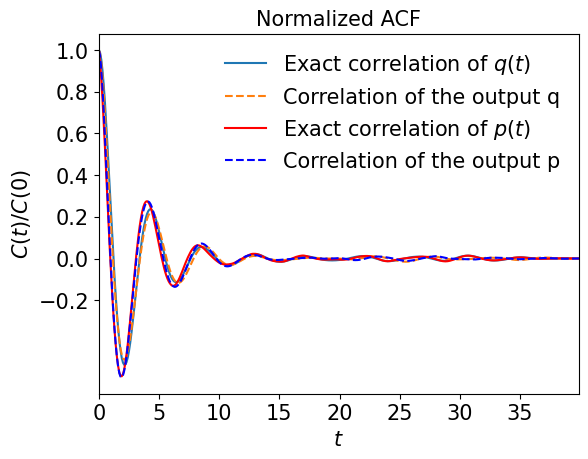

In [20]:
# Test 2: plot the ACF of the sample path generated by the SINN and the exact ACF  

acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
acf_t=StatLoss.acf(target)
# corr_p=acf_p.mean(axis=1).detach().cpu().numpy()
# corr_t=acf_t.mean(axis=1).detach().cpu().numpy()
corr_p=acf_p.detach().cpu().numpy()
corr_t=acf_t.detach().cpu().numpy()


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, corr_t[...,0],'',label=r'Exact correlation of $q(t)$')        # correlation function of the target 
plt.plot(T, corr_p[...,0], '--',label=r'Correlation of the output q')        # Correlation function after the training      # Correlation function after the training 
plt.plot(T, corr_t[...,1],'r',label=r'Exact correlation of $p(t)$')        # correlation function of the target 
plt.plot(T, corr_p[...,1], 'b--',label=r'Correlation of the output p')        # Correlation function after the training      # Correlation function after the training 

plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.xlim(0,T[-1])
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

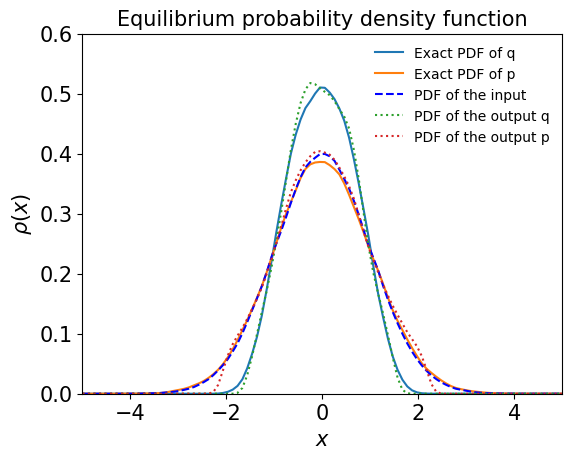

In [21]:
# Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
rho_data =  StatLoss.gauss_kde(target, -5, 5, 100).cpu()
rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100).cpu()
rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100).cpu()


x=np.linspace(-5, 5, 100)
fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r"Equilibrium probability density function",fontsize=15)    
plt.plot(x, rho_data.numpy()[...,0],label=r'Exact PDF of q')    # target PDF
plt.plot(x, rho_data.numpy()[...,1],label=r'Exact PDF of p')    # target PDF
plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
plt.plot(x, rho_prediction.numpy()[...,0], ':',label=r'PDF of the output q')  # PDF after the training 
plt.plot(x, rho_prediction.numpy()[...,1], ':',label=r'PDF of the output p')  # PDF after the training 
plt.xlim(-5,5)
plt.ylim(0,0.6)
plt.xlabel(r'$x$',fontsize=15)
plt.ylabel(r'$\rho(x)$',fontsize=15)
plt.legend(frameon=False,fontsize=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

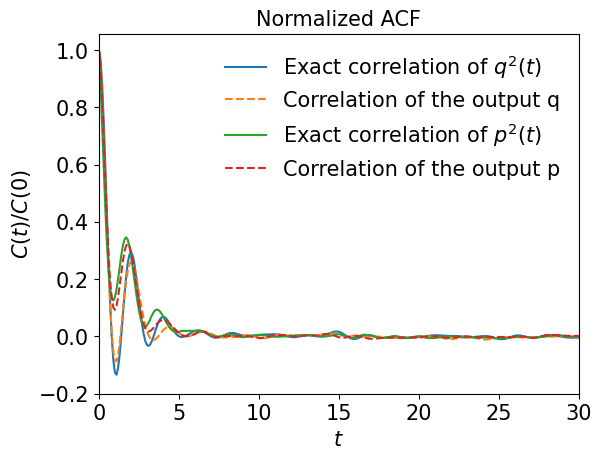

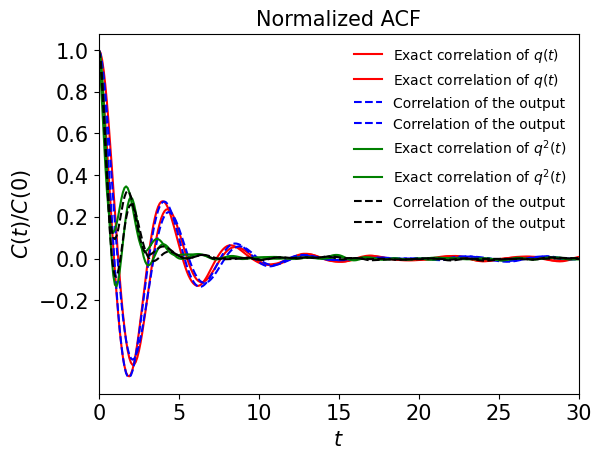

In [22]:
# Test 4: Comparing the higher-order ACF
acf2=StatLoss.acf(target**2)
pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,2))
acf2_app=StatLoss.acf(pred_norm**2)

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
# plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'r',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
# plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'g--',label=r'Correlation of the output')        # Correlation function after the training 
plt.plot(T, acf2.detach().cpu().numpy()[...,0],label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.detach().cpu().numpy()[...,0], '--',label=r'Correlation of the output q')        # Correlation function after the training 
plt.plot(T, acf2.detach().cpu().numpy()[...,1],label=r'Exact correlation of $p^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.detach().cpu().numpy()[...,1], '--',label=r'Correlation of the output p')        # Correlation function after the training 
plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/FPU_acf2.pdf", dpi=150)


fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)  
plt.plot(T, corr_t,'r',label=r'Exact correlation of $q(t)$')        # correlation function of the target 
plt.plot(T, corr_p, 'b--',label=r'Correlation of the output')   
# plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'g',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
# plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'k--',label=r'Correlation of the output')        # Correlation function after the training 
plt.plot(T, acf2.detach().cpu().numpy(),'g',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.detach().cpu().numpy(), 'k--',label=r'Correlation of the output')        # Correlation function after the training 
plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=10)

(array([  0., 100., 200., 300., 400., 500.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

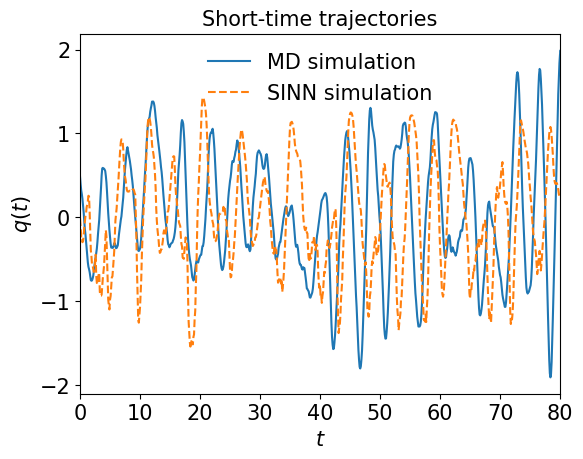

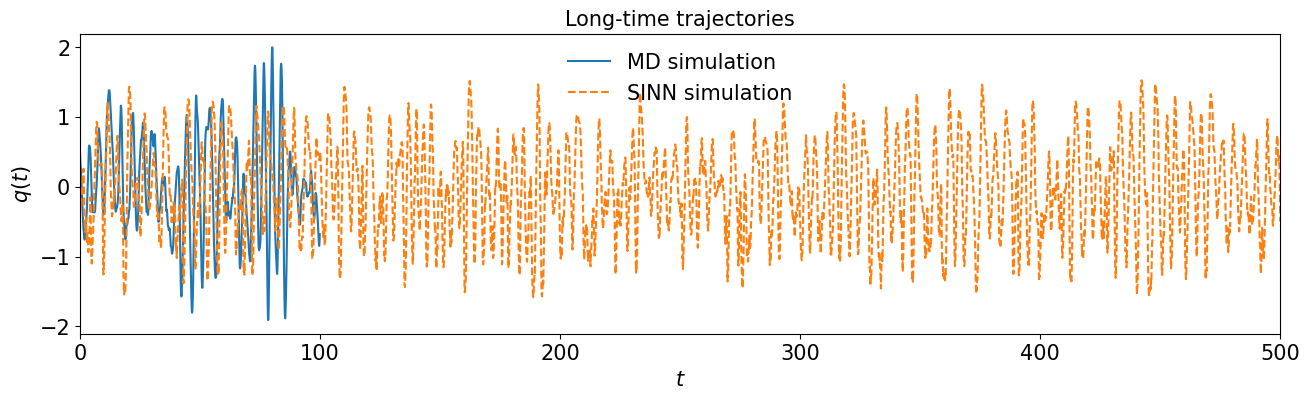

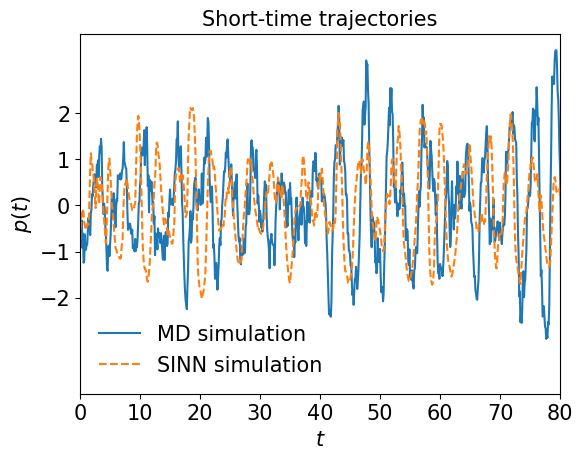

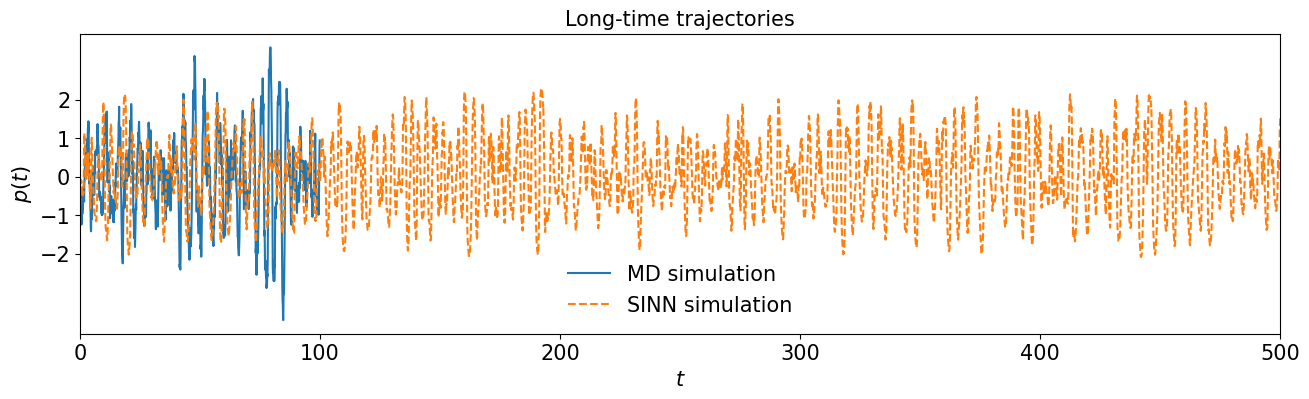

In [24]:
# Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 
[a,b,c]=input.size()
skip=20
scale=10
burnin=3
fold=800
batch_new=50
ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
Pred_L, _= net(ran_input)
prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new,2)
acf_p=StatLoss.acf(Pred_L,method='bruteforce')

LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
LT=LT[0:-1]


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Short-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q2_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 1,0],'--',label='SINN simulation')
plt.xlim([0,80])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/FPU_traj_sT.pdf", dpi=150)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Long-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q2_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 1,0],'--',label='SINN simulation')
plt.xlim([0,500])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)

fig = plt.figure(2)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Short-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],p2_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 1,1],'--',label='SINN simulation')
plt.xlim([0,80])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/FPU_traj_sT.pdf", dpi=150)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Long-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],p2_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 1,1],'--',label='SINN simulation')
plt.xlim([0,500])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)

## 1.2. Loss function=CCF($\textbf{x}$)+PDF($\textbf{x}$)+CCF($\textbf{x}^2$)

In [25]:
### Defining SINN model
net = SINN(1, 5, 2, 2).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [26]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_ccf_fft(prediction) + loss_pdf_empirical(prediction) + loss_ccf_sec_moment(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical(pred_val) + loss_ccf_sec_moment(pred_val**2)
            loss_val_ccf = loss_ccf_bruteforce(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.0005 and loss_val<=0.0005:
            break
print('Training finished')

[0]-th step loss: 0.279, 0.277
[50]-th step loss: 0.271, 0.271
[100]-th step loss: 0.264, 0.263
[150]-th step loss: 0.169, 0.168
[200]-th step loss: 0.152, 0.151
[250]-th step loss: 0.129, 0.127
[300]-th step loss: 0.052, 0.052
[350]-th step loss: 0.037, 0.037
[400]-th step loss: 0.029, 0.029
[450]-th step loss: 0.023, 0.023
[500]-th step loss: 0.018, 0.018
[550]-th step loss: 0.013, 0.013
[600]-th step loss: 0.008, 0.008
[650]-th step loss: 0.005, 0.005
[700]-th step loss: 0.004, 0.004
[750]-th step loss: 0.004, 0.004
[800]-th step loss: 0.003, 0.003
[850]-th step loss: 0.003, 0.003
[900]-th step loss: 0.003, 0.003
[950]-th step loss: 0.003, 0.004
[1000]-th step loss: 0.015, 0.015
[1050]-th step loss: 0.009, 0.008
[1100]-th step loss: 0.006, 0.007
[1150]-th step loss: 0.006, 0.005
[1200]-th step loss: 0.004, 0.004
[1250]-th step loss: 0.004, 0.003
[1300]-th step loss: 0.003, 0.003
[1350]-th step loss: 0.003, 0.002
[1400]-th step loss: 0.002, 0.002
[1450]-th step loss: 0.002, 0.002
[15

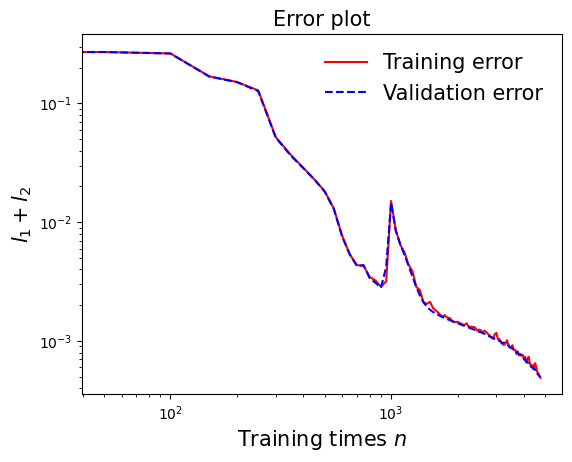

In [27]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [28]:
# # Gaussian random input
ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
Pred,_= net(ran_input)
prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)

([<matplotlib.axis.YTick at 0x1456d408a3d0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

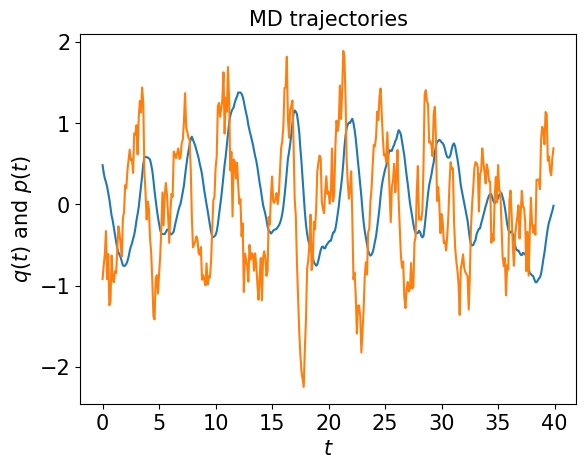

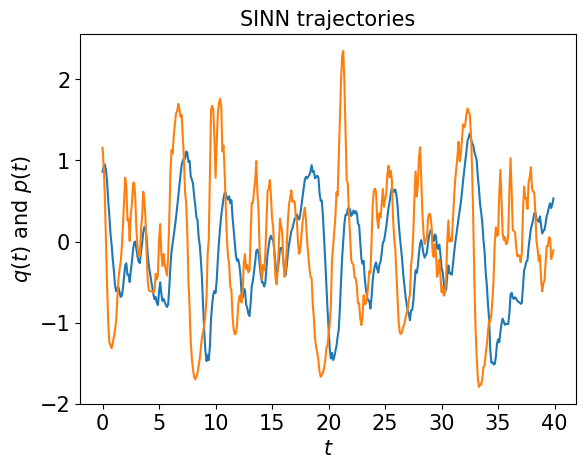

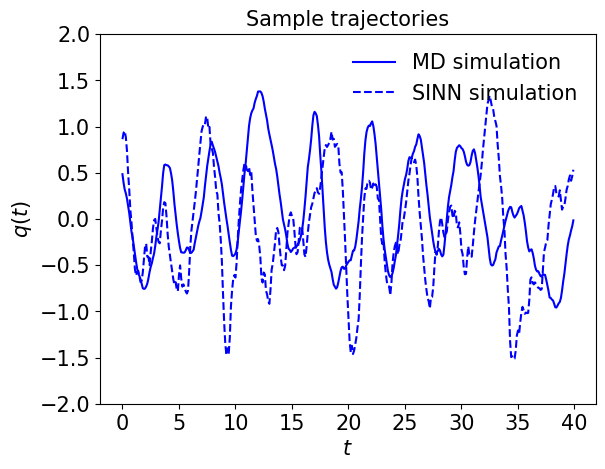

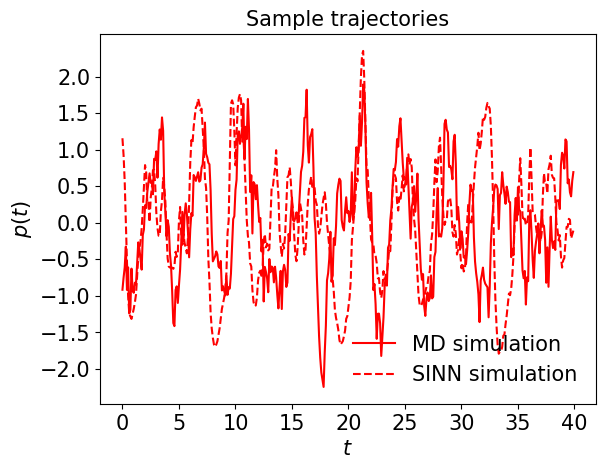

In [29]:
# Test 1: plot the sample path generated by SINN and the exact sample path 
skip = 0

fig = plt.figure(0)
plt.title("MD trajectories",fontsize=15) 
plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$ and $p(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15) 
# plt.savefig("figs/FPU_traj_multi_MD.pdf", dpi=150)

fig = plt.figure(1)
plt.title("SINN trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], prediction[skip:, 7])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$ and $p(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/FPU_traj_multi.pdf", dpi=150)


fig = plt.figure(2)
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 0,0], 'b',label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 7,0],'b--',label='SINN simulation')
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)

fig = plt.figure(3)
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 0,1],'r', label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 7,1],'r--',label='SINN simulation')
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)

([<matplotlib.axis.YTick at 0x1456b4cbc760>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

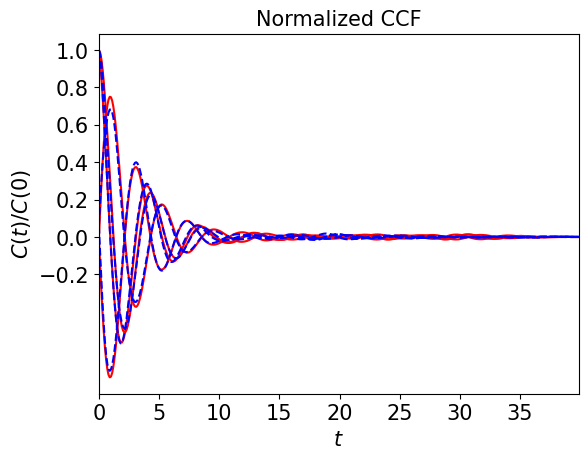

In [30]:
# Test 2: plot the ACF of the sample path generated by the SINN and the exact CCF  

ccf_p=StatLoss.ccf(Pred[-sec_length:,:,:])
ccf_t=StatLoss.ccf(target)
corr_p=ccf_p.detach().cpu().numpy()
corr_t=ccf_t.detach().cpu().numpy()


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized CCF',fontsize=15)    
plt.plot(T, corr_t,'r')        # correlation function of the target 
plt.plot(T, corr_p, 'b--')        # Correlation function after the training      # Correlation function after the training 
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.xlim(0,T[-1])
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
# plt.legend(frameon=False,fontsize=15)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

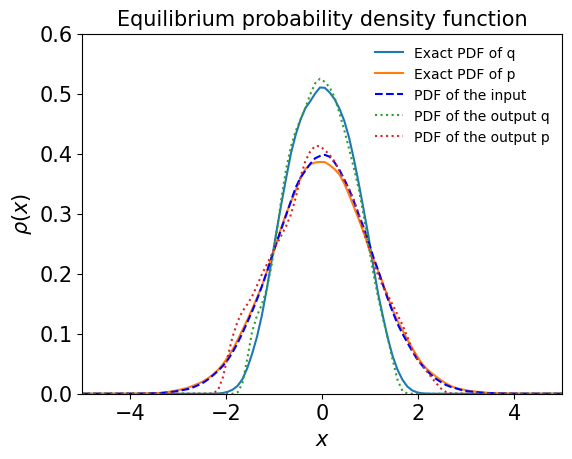

In [31]:
# Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
rho_data =  StatLoss.gauss_kde(target, -5, 5, 100).cpu()
rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100).cpu()
rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100).cpu()


x=np.linspace(-5, 5, 100)
fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r"Equilibrium probability density function",fontsize=15)    
plt.plot(x, rho_data.numpy()[...,0],label=r'Exact PDF of q')    # target PDF
plt.plot(x, rho_data.numpy()[...,1],label=r'Exact PDF of p')    # target PDF
plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
plt.plot(x, rho_prediction.numpy()[...,0], ':',label=r'PDF of the output q')  # PDF after the training 
plt.plot(x, rho_prediction.numpy()[...,1], ':',label=r'PDF of the output p')  # PDF after the training 
plt.xlim(-5,5)
plt.ylim(0,0.6)
plt.xlabel(r'$x$',fontsize=15)
plt.ylabel(r'$\rho(x)$',fontsize=15)
plt.legend(frameon=False,fontsize=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

([<matplotlib.axis.YTick at 0x14f10a5fad00>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

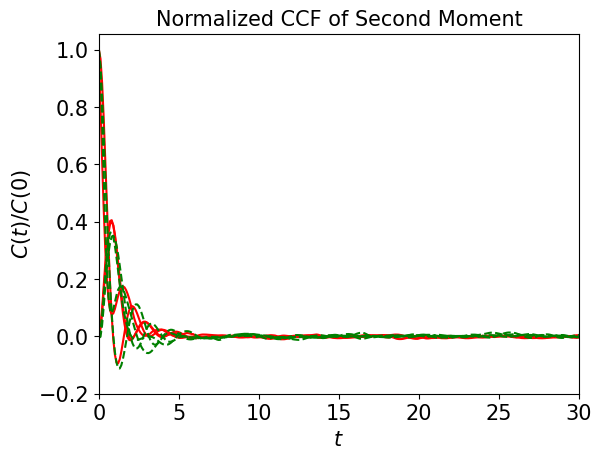

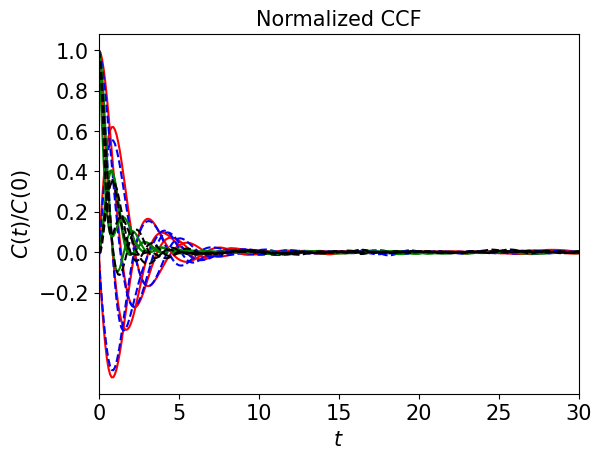

In [31]:
# Test 4: Comparing the higher-order CCF
ccf2=StatLoss.ccf(target**2)
pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,2))
ccf2_app=StatLoss.ccf(pred_norm**2)

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized CCF of Second Moment',fontsize=15)    
plt.plot(T, ccf2.detach().cpu().numpy(),'r',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
plt.plot(T, ccf2_app.detach().cpu().numpy(), 'g--',label=r'Correlation of the output')        # Correlation function after the training 

plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
# plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/FPU_acf2.pdf", dpi=150)


fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized CCF',fontsize=15)  
plt.plot(T, corr_t,'r',label=r'Exact correlation of $q(t)$')        # correlation function of the target 
plt.plot(T, corr_p, 'b--',label=r'Correlation of the output')   
# plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'g',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
# plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'k--',label=r'Correlation of the output')        # Correlation function after the training 
plt.plot(T, ccf2.detach().cpu().numpy(),'g',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
plt.plot(T, ccf2_app.detach().cpu().numpy(), 'k--',label=r'Correlation of the output')        # Correlation function after the training 
plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
# plt.legend(frameon=False,fontsize=10)

(array([  0., 100., 200., 300., 400., 500.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

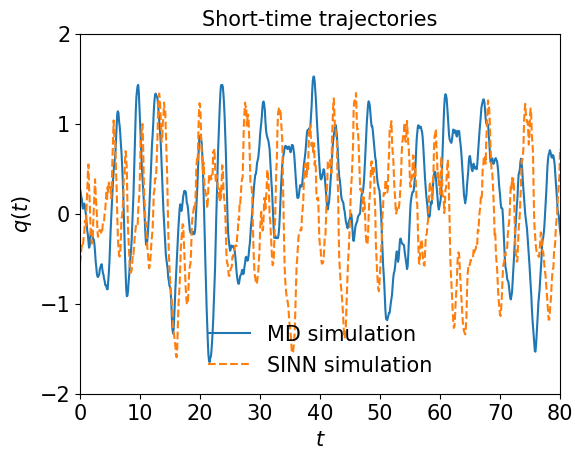

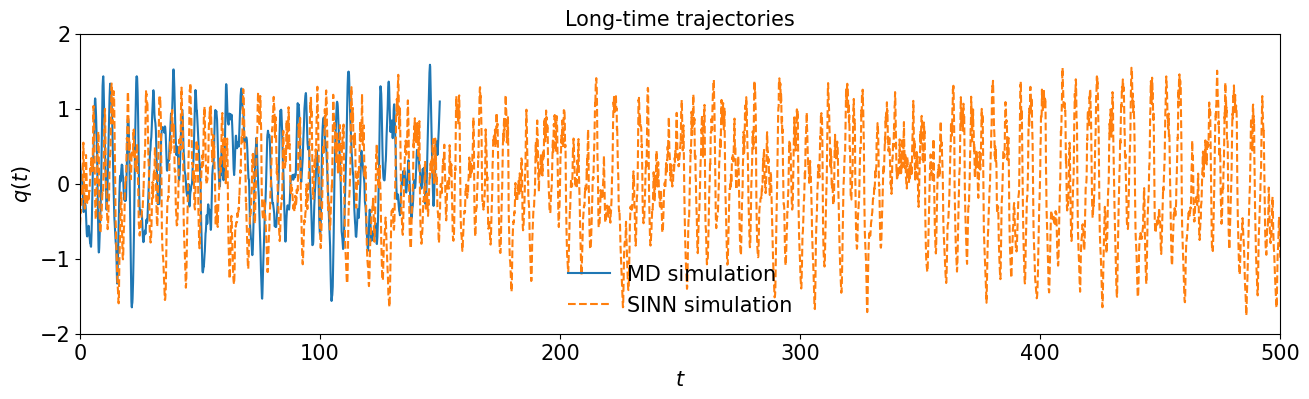

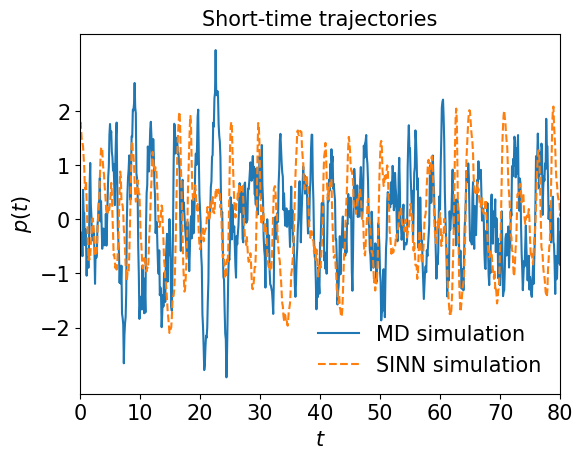

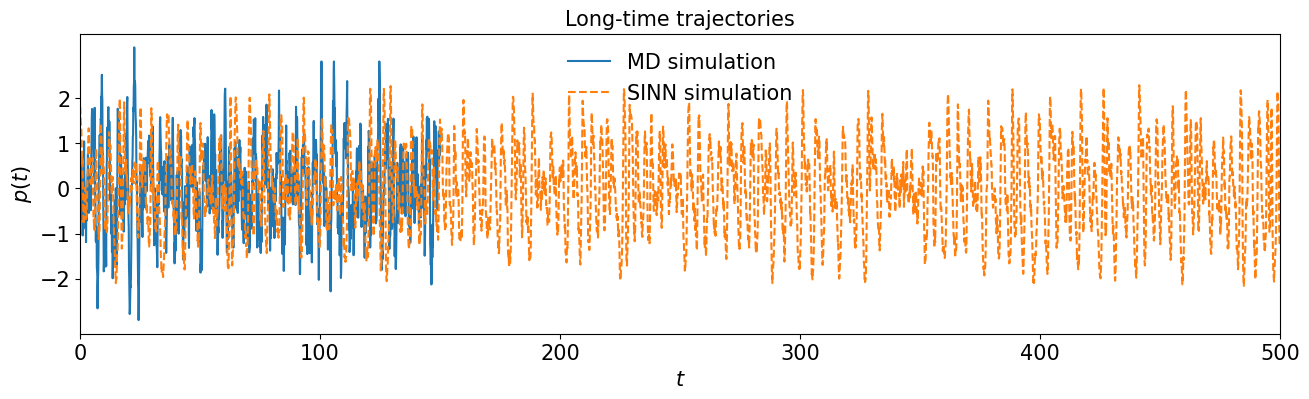

In [33]:
# Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 
[a,b,c]=input.size()
skip=20
scale=10
burnin=3
fold=800
batch_new=50
ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
Pred_L, _= net(ran_input)
prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new,2)
ccf_p=StatLoss.ccf(Pred_L,method='bruteforce')

LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
LT=LT[0:-1]


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Short-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q1_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
plt.xlim([0,80])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/FPU_traj_sT.pdf", dpi=150)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Long-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q1_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
plt.xlim([0,500])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)

fig = plt.figure(2)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Short-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],p1_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
plt.xlim([0,80])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/FPU_traj_sT.pdf", dpi=150)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Long-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],p1_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
plt.xlim([0,500])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)

## 1.3. Loss function=CCF($\textbf{x}$)+PDF($\textbf{x}$)+ACF($\textbf{x}^2$)

In [34]:
### Defining SINN model
net = SINN(1, 5, 2, 2).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [35]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_ccf_fft(prediction) + loss_pdf_empirical(prediction) + loss_acf_sec_moment(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical(pred_val) + loss_acf_sec_moment(pred_val**2)
            loss_val_ccf = loss_ccf_bruteforce(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.001 and loss_val<=0.001:
            break
print('Training finished')

[0]-th step loss: 0.268, 0.268
[50]-th step loss: 0.252, 0.251
[100]-th step loss: 0.092, 0.089
[150]-th step loss: 0.034, 0.033
[200]-th step loss: 0.014, 0.014
[250]-th step loss: 0.006, 0.006
[300]-th step loss: 0.004, 0.004
[350]-th step loss: 0.003, 0.003
[400]-th step loss: 0.003, 0.003
[450]-th step loss: 0.002, 0.002
[500]-th step loss: 0.002, 0.002
[550]-th step loss: 0.002, 0.002
[600]-th step loss: 0.001, 0.001
[650]-th step loss: 0.001, 0.001
[700]-th step loss: 0.001, 0.001
[750]-th step loss: 0.001, 0.001
Training finished
CPU times: user 29.3 s, sys: 53.6 ms, total: 29.3 s
Wall time: 29.4 s


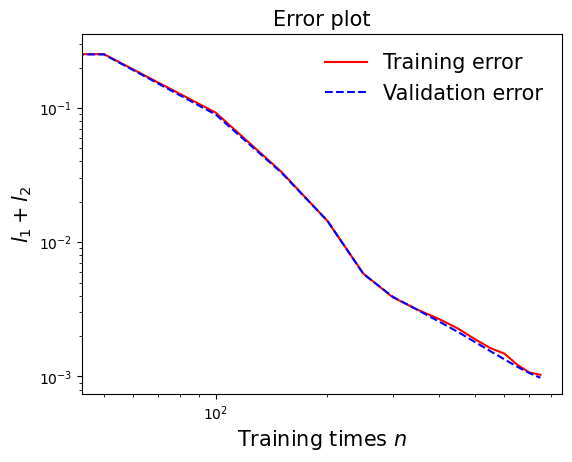

In [36]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [38]:
# # Gaussian random input
ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
Pred,_= net(ran_input)
prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)

([<matplotlib.axis.YTick at 0x14f0dc2cbcd0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

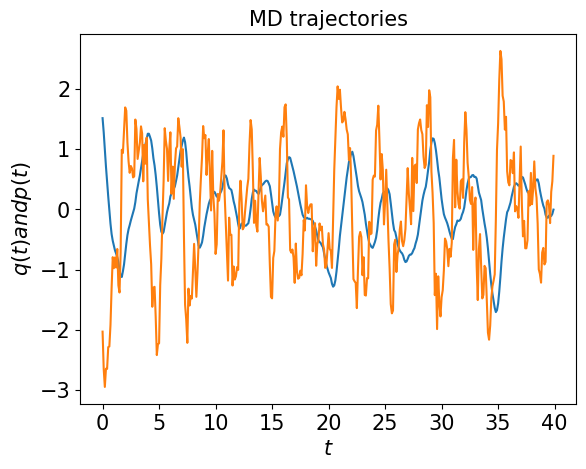

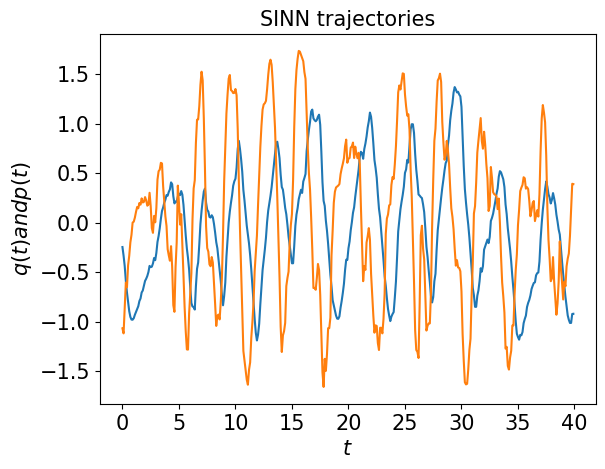

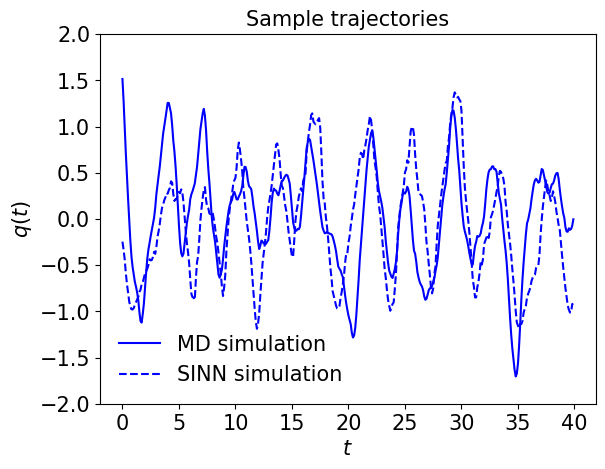

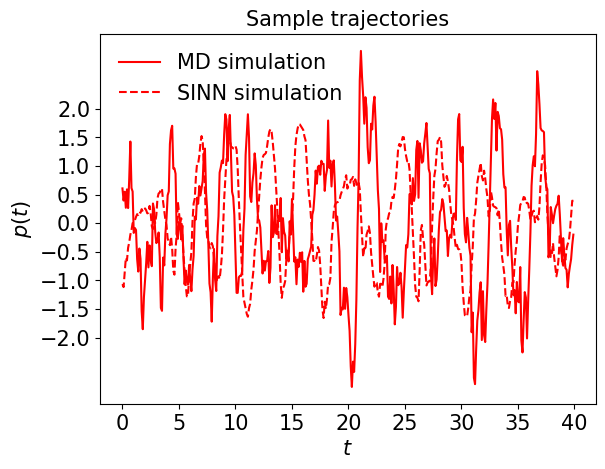

In [39]:
# Test 1: plot the sample path generated by SINN and the exact sample path 
skip = 0

fig = plt.figure(0)
plt.title("MD trajectories",fontsize=15) 
plt.plot(T[skip:]-T[skip], Traj[skip:, 5])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t) and p(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15) 
# plt.savefig("figs/FPU_traj_multi_MD.pdf", dpi=150)

fig = plt.figure(1)
plt.title("SINN trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], prediction[skip:, 2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t) and p(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/FPU_traj_multi.pdf", dpi=150)


fig = plt.figure(2)
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:,5, 0], 'b',label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 2, 0],'b--',label='SINN simulation')
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)

fig = plt.figure(3)
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 2, 1],'r', label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 2, 1],'r--',label='SINN simulation')
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)

([<matplotlib.axis.YTick at 0x14f10a533790>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

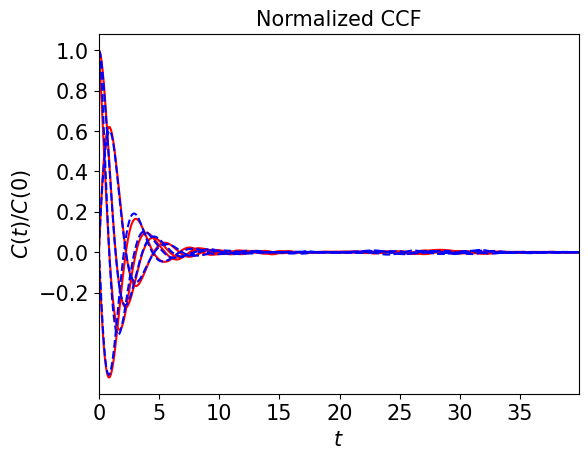

In [40]:
# Test 2: plot the ACF of the sample path generated by the SINN and the exact ACF  

ccf_p=StatLoss.ccf(Pred[-sec_length:,:,:])
ccf_t=StatLoss.ccf(target)
corr_p=ccf_p.detach().cpu().numpy()
corr_t=ccf_t.detach().cpu().numpy()


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized CCF',fontsize=15)    
plt.plot(T, corr_t,'r')        # correlation function of the target 
plt.plot(T, corr_p, 'b--')        # Correlation function after the training      # Correlation function after the training 
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.xlim(0,T[-1])
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

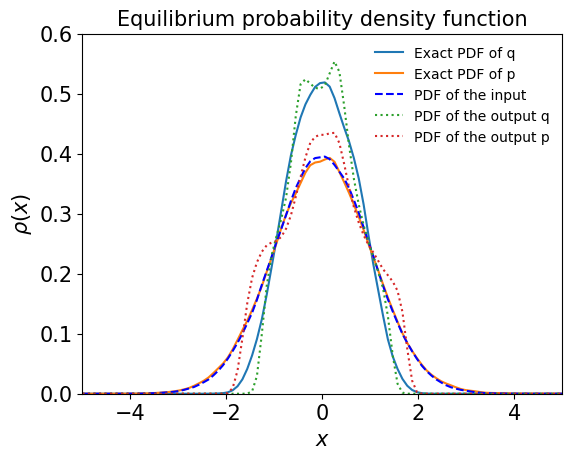

In [41]:
# Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
rho_data =  StatLoss.gauss_kde(target, -5, 5, 100).cpu()
rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100).cpu()
rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100).cpu()


x=np.linspace(-5, 5, 100)
fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r"Equilibrium probability density function",fontsize=15)    
plt.plot(x, rho_data.numpy()[...,0],label=r'Exact PDF of q')    # target PDF
plt.plot(x, rho_data.numpy()[...,1],label=r'Exact PDF of p')    # target PDF
plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
plt.plot(x, rho_prediction.numpy()[...,0], ':',label=r'PDF of the output q')  # PDF after the training 
plt.plot(x, rho_prediction.numpy()[...,1], ':',label=r'PDF of the output p')  # PDF after the training 
plt.xlim(-5,5)
plt.ylim(0,0.6)
plt.xlabel(r'$x$',fontsize=15)
plt.ylabel(r'$\rho(x)$',fontsize=15)
plt.legend(frameon=False,fontsize=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

([<matplotlib.axis.YTick at 0x14f0b2db9130>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

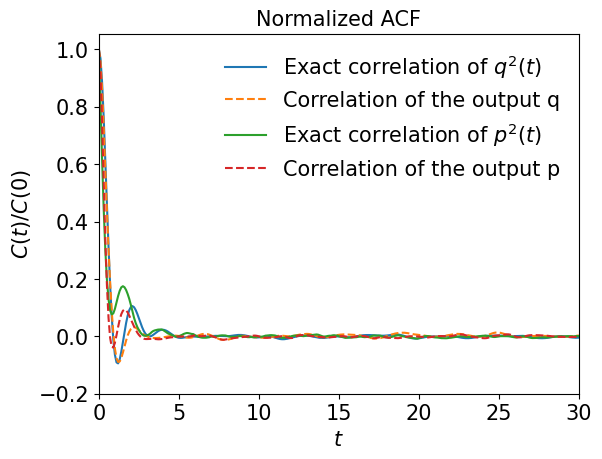

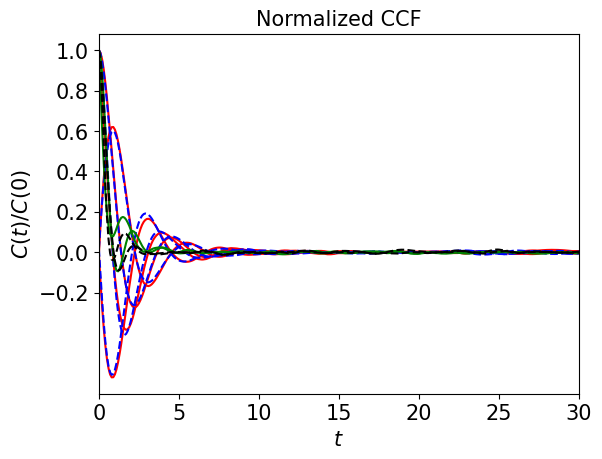

In [42]:
# Test 4: Comparing the higher-order ACF
acf2=StatLoss.acf(target**2)
pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,2))
acf2_app=StatLoss.acf(pred_norm**2)

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, acf2.detach().cpu().numpy()[...,0],'',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.detach().cpu().numpy()[...,0], '--',label=r'Correlation of the output q')        # Correlation function after the training 
plt.plot(T, acf2.detach().cpu().numpy()[...,1],'',label=r'Exact correlation of $p^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.detach().cpu().numpy()[...,1], '--',label=r'Correlation of the output p')        # Correlation function after the training 

plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/FPU_acf2.pdf", dpi=150)


fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized CCF',fontsize=15)  
plt.plot(T, corr_t,'r',label=r'Exact correlation of $q(t)$')        # correlation function of the target 
plt.plot(T, corr_p, 'b--',label=r'Correlation of the output')   
# plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'g',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
# plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'k--',label=r'Correlation of the output')        # Correlation function after the training 
plt.plot(T, acf2.detach().cpu().numpy(),'g',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.detach().cpu().numpy(), 'k--',label=r'Correlation of the output')        # Correlation function after the training 
plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)

(array([  0., 100., 200., 300., 400., 500.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

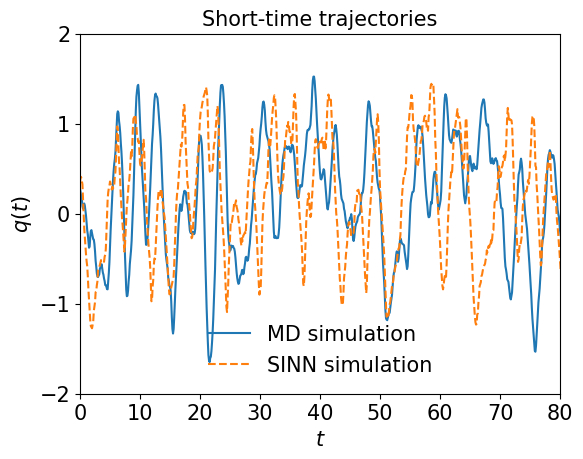

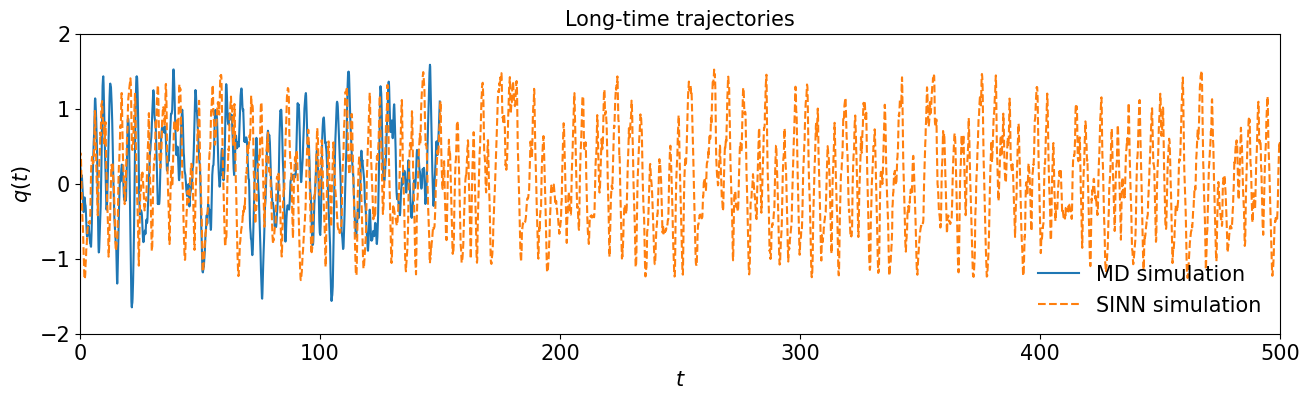

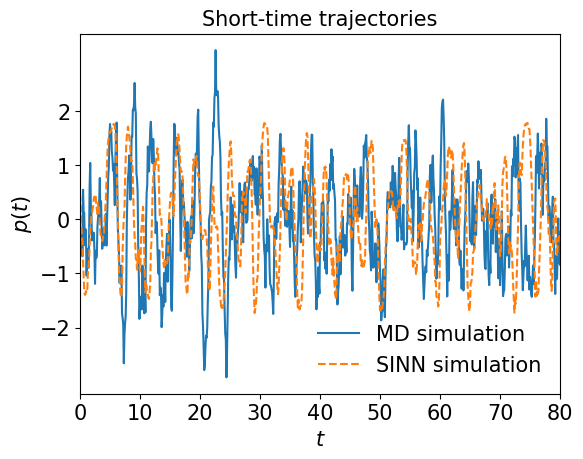

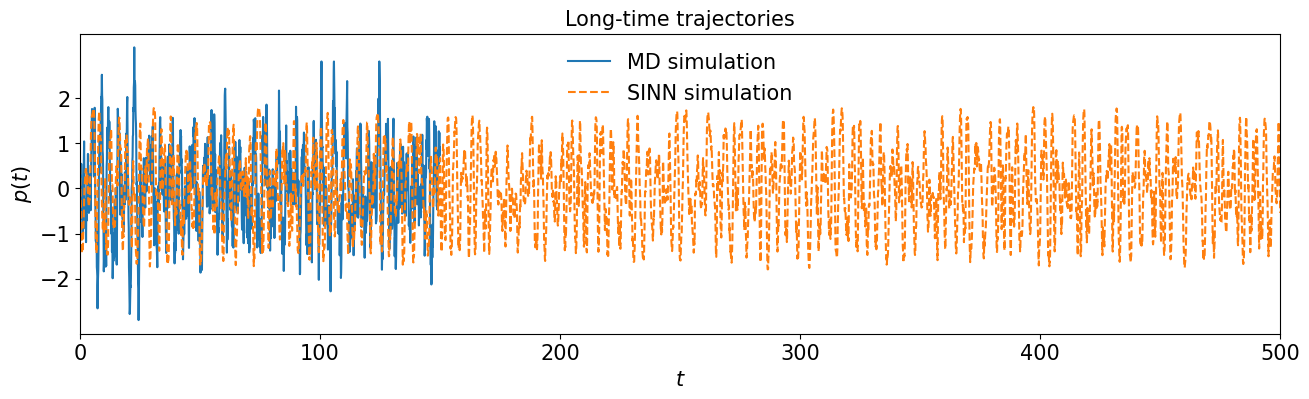

In [44]:
# Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 
[a,b,c]=input.size()
skip=20
scale=10
burnin=3
fold=800
batch_new=50
ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
Pred_L, _= net(ran_input)
prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new,2)
ccf_p=StatLoss.ccf(Pred_L,method='bruteforce')

LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
LT=LT[0:-1]


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Short-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q1_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
plt.xlim([0,80])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/FPU_traj_sT.pdf", dpi=150)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Long-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q1_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
plt.xlim([0,500])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)

fig = plt.figure(2)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Short-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],p1_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
plt.xlim([0,80])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/FPU_traj_sT.pdf", dpi=150)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Long-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],p1_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
plt.xlim([0,500])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)

# 2. 2 inputs

In [45]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,2*batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 2)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 2), device=device)


Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 2]) torch.float32
The torch validation size is torch.Size([800, 400, 2]) torch.float32
The torch target size is torch.Size([400, 400, 2]) torch.float32


In [46]:
# Defining Loss functions
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_sec_moment = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_ccf_fft = make_loss('ccf[fft]', target, lags=LAGS, device=device)
loss_ccf_sec_moment = make_loss('ccf[fft]', target**2, lags=LAGS, device=device)
loss_ccf_bruteforce = make_loss('ccf[bruteforce]', target, lags=LAGS, device=device)
loss_ccf_randbrute = make_loss('ccf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_pdf_empirical = make_loss('pdf', target, lower=-5, upper=5, n=N, device=device)

## 2.1. Loss function=ACF($\textbf{x}$)+PDF($\textbf{x}$)+ACF($\textbf{x}^2$)

In [47]:
### Defining SINN model
net = SINN(2, 5, 2, 2).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [48]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,2*batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,2)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_acf_fft(prediction) + loss_pdf_empirical(prediction) + loss_acf_sec_moment(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_empirical(pred_val) + loss_acf_sec_moment(pred_val**2)
            loss_val_acf = loss_acf_bruteforce(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.001 and loss_val<=0.001:
            break
print('Training finished')

[0]-th step loss: 0.268, 0.268
[50]-th step loss: 0.250, 0.249
[100]-th step loss: 0.083, 0.082
[150]-th step loss: 0.047, 0.046
[200]-th step loss: 0.031, 0.031
[250]-th step loss: 0.022, 0.023
[300]-th step loss: 0.016, 0.016
[350]-th step loss: 0.012, 0.012
[400]-th step loss: 0.010, 0.009
[450]-th step loss: 0.008, 0.008
[500]-th step loss: 0.007, 0.006
[550]-th step loss: 0.005, 0.005
[600]-th step loss: 0.004, 0.004
[650]-th step loss: 0.004, 0.004
[700]-th step loss: 0.003, 0.003
[750]-th step loss: 0.003, 0.003
[800]-th step loss: 0.003, 0.003
[850]-th step loss: 0.003, 0.003
[900]-th step loss: 0.003, 0.003
[950]-th step loss: 0.002, 0.002
[1000]-th step loss: 0.002, 0.002
[1050]-th step loss: 0.002, 0.002
[1100]-th step loss: 0.002, 0.002
[1150]-th step loss: 0.002, 0.002
[1200]-th step loss: 0.002, 0.002
[1250]-th step loss: 0.001, 0.001
[1300]-th step loss: 0.001, 0.001
[1350]-th step loss: 0.001, 0.001
[1400]-th step loss: 0.001, 0.001
Training finished
CPU times: user 59.

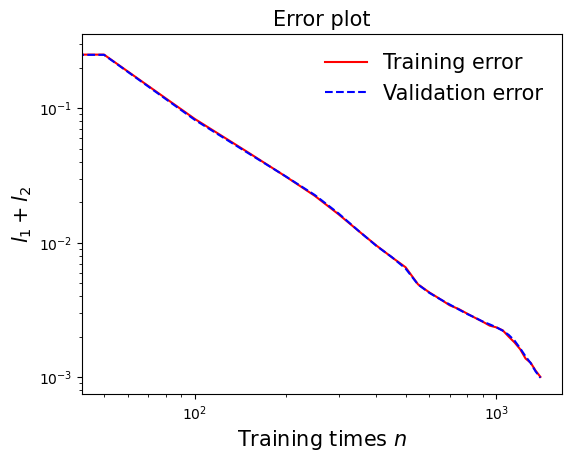

In [49]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [50]:
# # Gaussian random input
ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
Pred,_= net(ran_input)
prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)

([<matplotlib.axis.YTick at 0x14f10a5185e0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

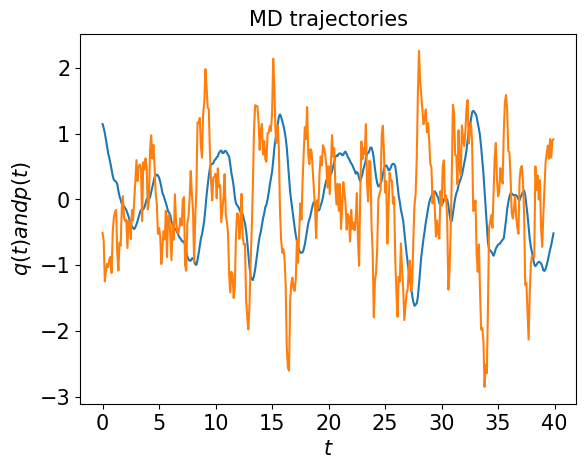

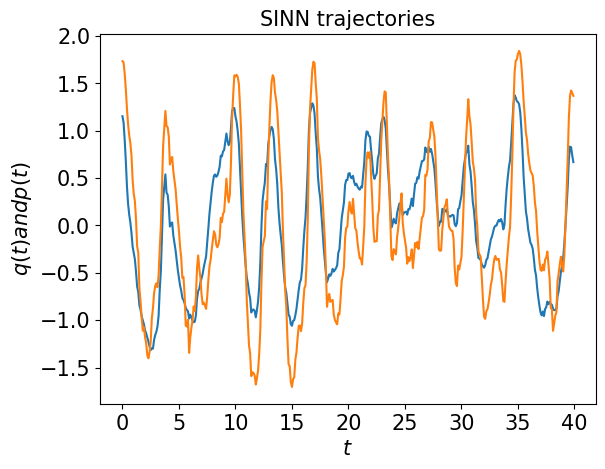

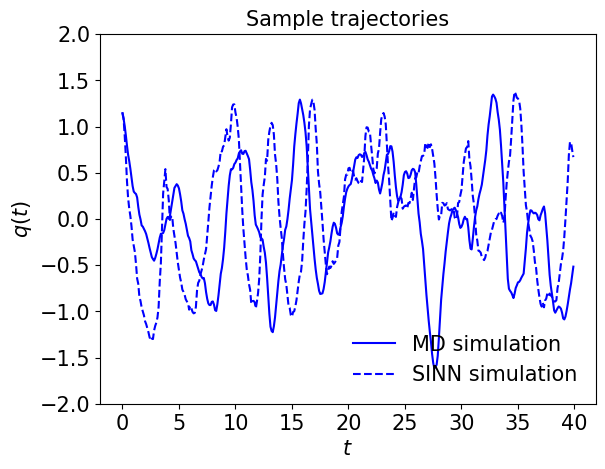

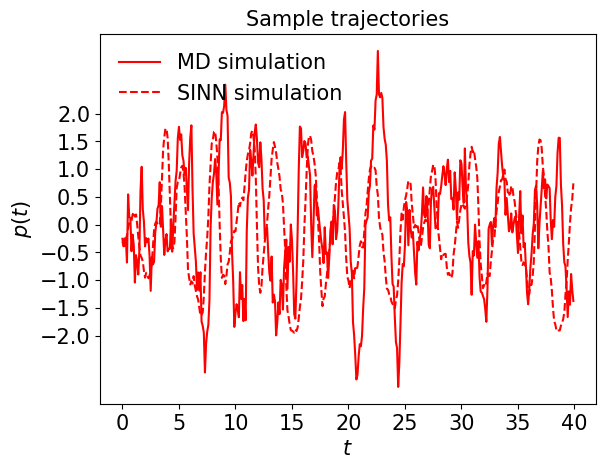

In [51]:
# Test 1: plot the sample path generated by SINN and the exact sample path 
skip = 0

fig = plt.figure(0)
plt.title("MD trajectories",fontsize=15) 
plt.plot(T[skip:]-T[skip], Traj[skip:, 6])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t) and p(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.ylim((-6,4))
# plt.savefig("figs/FPU_traj_multi_MD.pdf", dpi=150)

fig = plt.figure(1)
plt.title("SINN trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], prediction[skip:, 4])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t) and p(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.ylim((-6,4))
# plt.savefig("figs/FPU_traj_multi.pdf", dpi=150)


fig = plt.figure(2)
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 6, 0], 'b',label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 4, 0],'b--',label='SINN simulation')
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)

fig = plt.figure(3)
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 0, 1],'r', label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 0, 1],'r--',label='SINN simulation')
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)

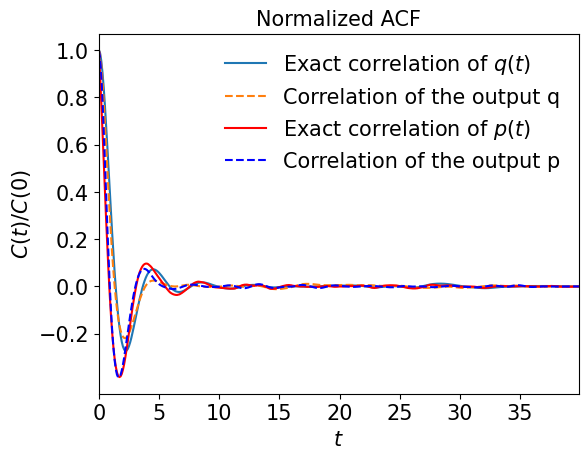

In [52]:
# Test 2: plot the ACF of the sample path generated by the SINN and the exact ACF  

acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
acf_t=StatLoss.acf(target)
corr_p=acf_p.detach().cpu().numpy()
corr_t=acf_t.detach().cpu().numpy()

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, corr_t[...,0],'',label=r'Exact correlation of $q(t)$')        # correlation function of the target 
plt.plot(T, corr_p[...,0], '--',label=r'Correlation of the output q')        # Correlation function after the training      # Correlation function after the training 
plt.plot(T, corr_t[...,1],'r',label=r'Exact correlation of $p(t)$')        # correlation function of the target 
plt.plot(T, corr_p[...,1], 'b--',label=r'Correlation of the output p')        # Correlation function after the training      # Correlation function after the training 

plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.xlim(0,T[-1])
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)

# fig = plt.figure(0)
# ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
# plt.title(r'Normalized CCF',fontsize=15)    
# plt.plot(T, corr_t,'r')        # correlation function of the target 
# plt.plot(T, corr_p, 'b--')        # Correlation function after the training      # Correlation function after the training 
# plt.xlabel(r'$t$',fontsize=15)
# plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
# plt.xticks(fontsize=15)
# plt.xlim(0,T[-1])
# plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

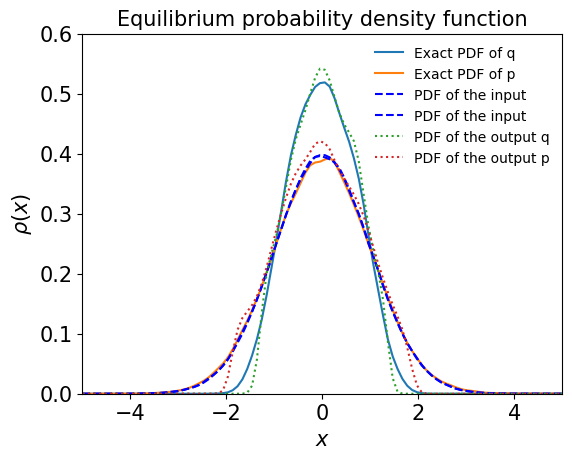

In [53]:
# Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
rho_data =  StatLoss.gauss_kde(target, -5, 5, 100).cpu()
rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100).cpu()
rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100).cpu()


x=np.linspace(-5, 5, 100)
fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r"Equilibrium probability density function",fontsize=15)    
plt.plot(x, rho_data.numpy()[...,0],label=r'Exact PDF of q')    # target PDF
plt.plot(x, rho_data.numpy()[...,1],label=r'Exact PDF of p')    # target PDF
plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
plt.plot(x, rho_prediction.numpy()[...,0], ':',label=r'PDF of the output q')  # PDF after the training 
plt.plot(x, rho_prediction.numpy()[...,1], ':',label=r'PDF of the output p')  # PDF after the training 
plt.xlim(-5,5)
plt.ylim(0,0.6)
plt.xlabel(r'$x$',fontsize=15)
plt.ylabel(r'$\rho(x)$',fontsize=15)
plt.legend(frameon=False,fontsize=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

([<matplotlib.axis.YTick at 0x14f10ab2ae20>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

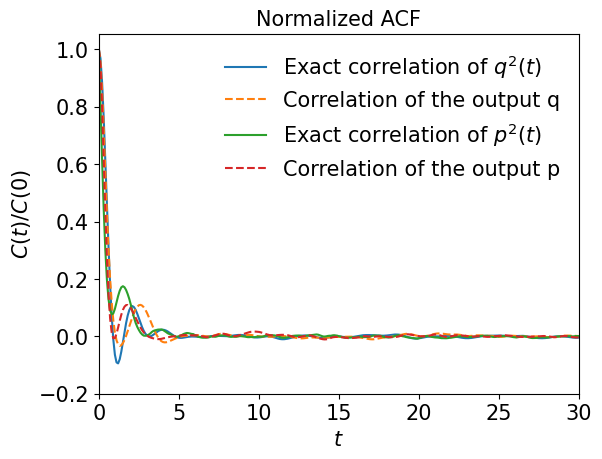

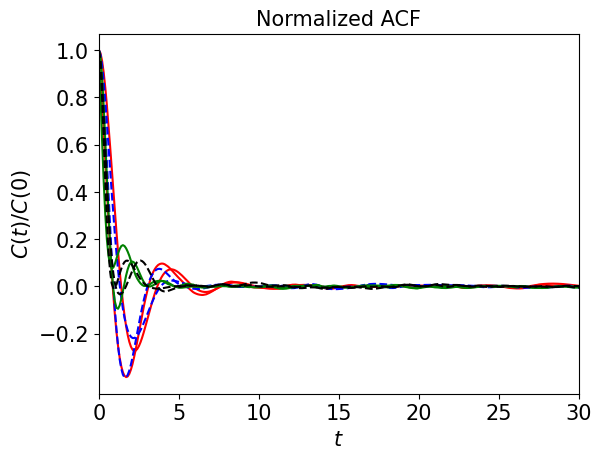

In [54]:
# Test 4: Comparing the higher-order ACF
acf2=StatLoss.acf(target**2)
pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,2))
acf2_app=StatLoss.acf(pred_norm**2)

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, acf2.detach().cpu().numpy()[...,0],'',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.detach().cpu().numpy()[...,0], '--',label=r'Correlation of the output q')        # Correlation function after the training 
plt.plot(T, acf2.detach().cpu().numpy()[...,1],'',label=r'Exact correlation of $p^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.detach().cpu().numpy()[...,1], '--',label=r'Correlation of the output p')        # Correlation function after the training 

plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/FPU_acf2.pdf", dpi=150)


fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)  
plt.plot(T, corr_t,'r',label=r'Exact correlation of $q(t)$')        # correlation function of the target 
plt.plot(T, corr_p, 'b--',label=r'Correlation of the output')   
# plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'g',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
# plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'k--',label=r'Correlation of the output')        # Correlation function after the training 
plt.plot(T, acf2.detach().cpu().numpy(),'g',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.detach().cpu().numpy(), 'k--',label=r'Correlation of the output')        # Correlation function after the training 
plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)

(array([  0., 100., 200., 300., 400., 500.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

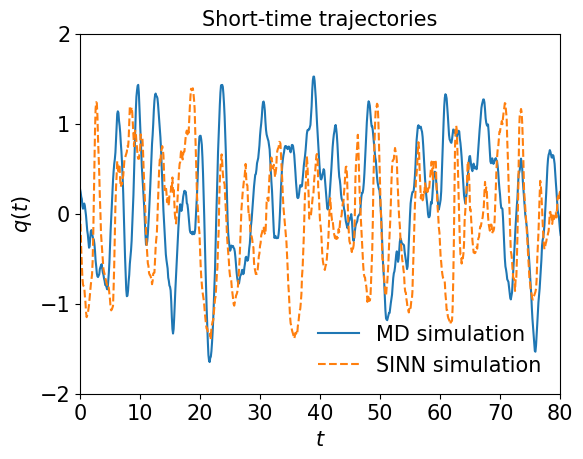

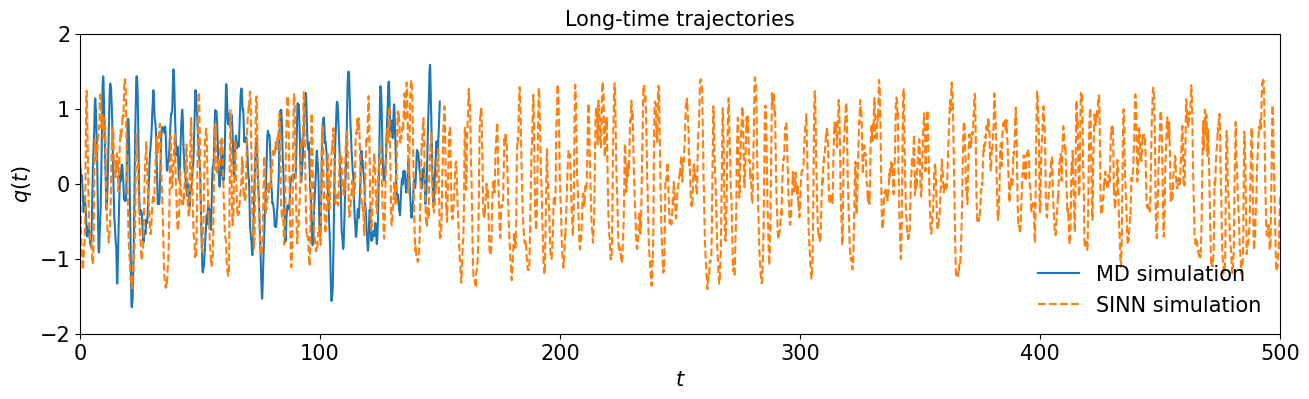

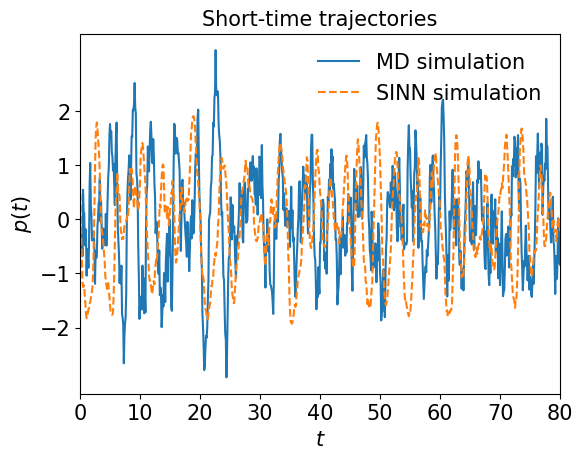

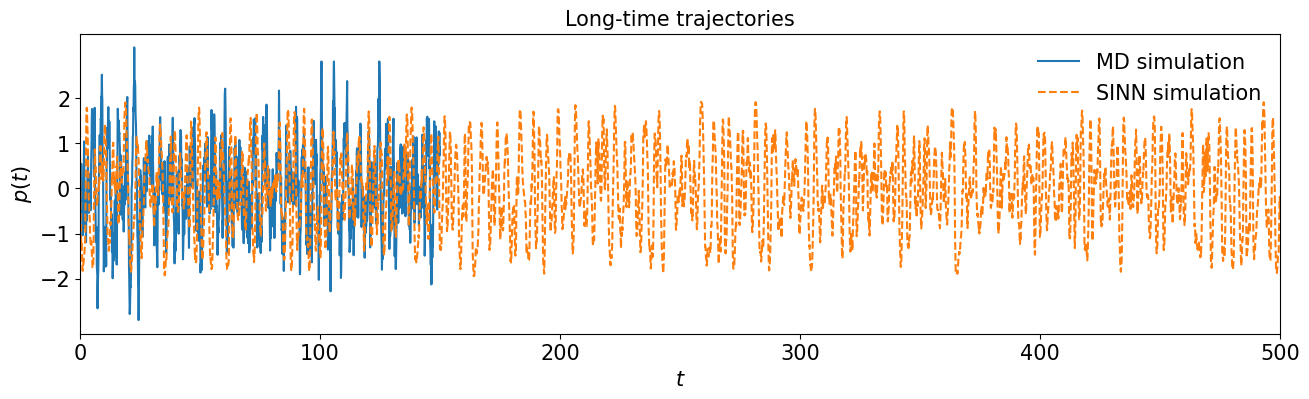

In [56]:
# Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 
[a,b,c]=input.size()
skip=20
scale=10
burnin=3
fold=800
batch_new=50
ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
Pred_L, _= net(ran_input)
prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new,2)
ccf_p=StatLoss.ccf(Pred_L,method='bruteforce')

LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
LT=LT[0:-1]


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Short-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q1_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
plt.xlim([0,80])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/FPU_traj_sT.pdf", dpi=150)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Long-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q1_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
plt.xlim([0,500])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)

fig = plt.figure(2)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Short-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],p1_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
plt.xlim([0,80])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/FPU_traj_sT.pdf", dpi=150)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Long-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],p1_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
plt.xlim([0,500])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)

## 2.2. Loss function=CCF($\textbf{x}$)+PDF($\textbf{x}$)+CCF($\textbf{x}^2$)

In [57]:
### Defining SINN model
net = SINN(2, 5, 2, 2).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [58]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,2*batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,2)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_ccf_fft(prediction) + loss_pdf_empirical(prediction) + loss_ccf_sec_moment(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical(pred_val) + loss_ccf_sec_moment(pred_val**2)
            loss_val_acf = loss_acf_bruteforce(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.001 and loss_val<=0.001:
            break
print('Training finished')

[0]-th step loss: 0.276, 0.275
[50]-th step loss: 0.263, 0.263
[100]-th step loss: 0.188, 0.185
[150]-th step loss: 0.056, 0.055
[200]-th step loss: 0.020, 0.020
[250]-th step loss: 0.012, 0.012
[300]-th step loss: 0.010, 0.009
[350]-th step loss: 0.008, 0.008
[400]-th step loss: 0.007, 0.007
[450]-th step loss: 0.006, 0.006
[500]-th step loss: 0.005, 0.005
[550]-th step loss: 0.004, 0.004
[600]-th step loss: 0.003, 0.003
[650]-th step loss: 0.002, 0.002
[700]-th step loss: 0.002, 0.002
[750]-th step loss: 0.001, 0.002
[800]-th step loss: 0.001, 0.001
[850]-th step loss: 0.001, 0.001
[900]-th step loss: 0.001, 0.001
[950]-th step loss: 0.001, 0.001
Training finished
CPU times: user 46.6 s, sys: 62.1 ms, total: 46.6 s
Wall time: 46.7 s


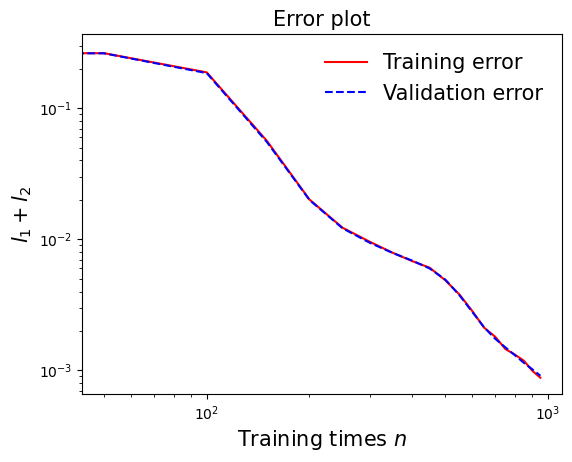

In [59]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [60]:
# # Gaussian random input
ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
Pred,_= net(ran_input)
prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)

([<matplotlib.axis.YTick at 0x14f10aa5d280>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

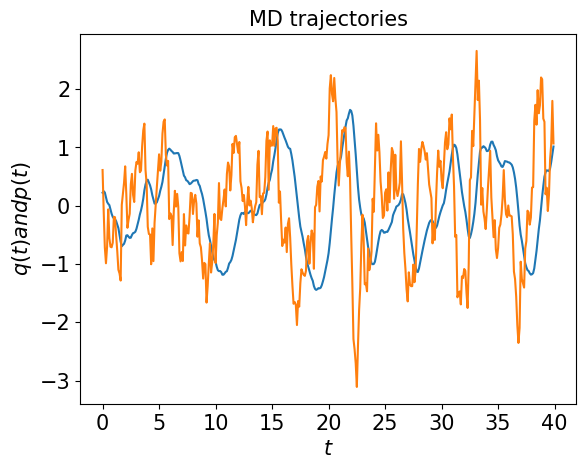

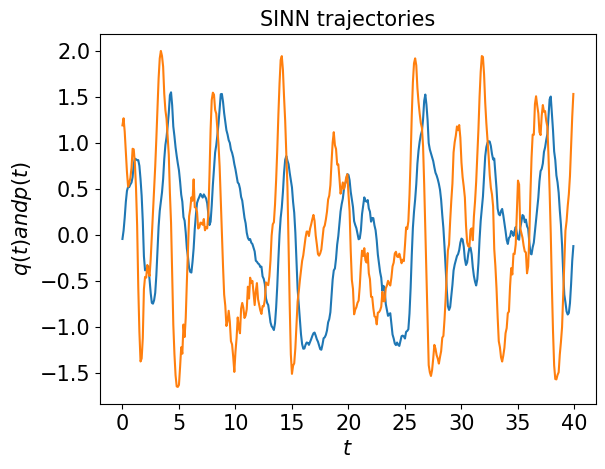

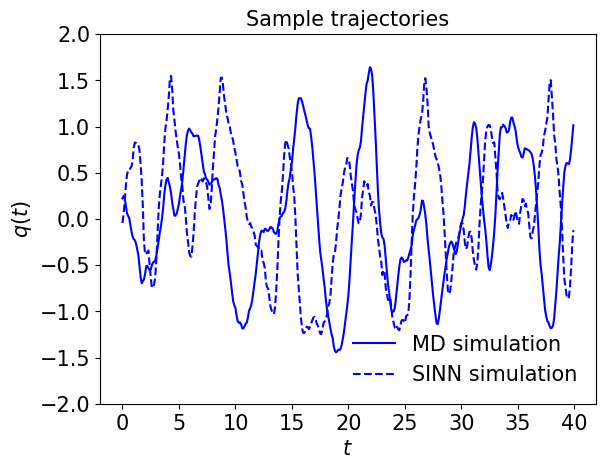

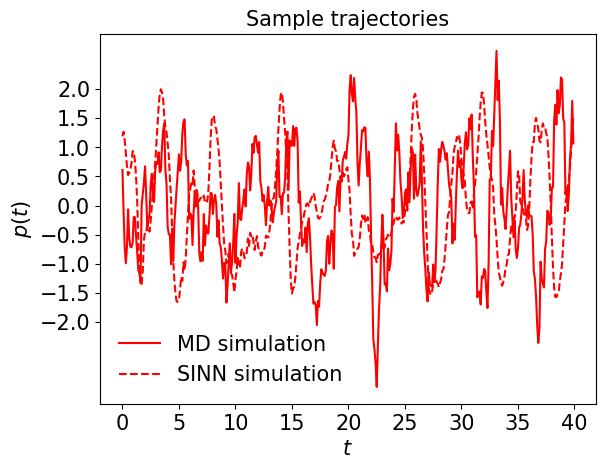

In [61]:
# Test 1: plot the sample path generated by SINN and the exact sample path 
skip = 0

fig = plt.figure(0)
plt.title("MD trajectories",fontsize=15) 
plt.plot(T[skip:]-T[skip], Traj[skip:, 1])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t) and p(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15) 
# plt.savefig("figs/FPU_traj_multi_MD.pdf", dpi=150)

fig = plt.figure(1)
plt.title("SINN trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], prediction[skip:, 2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t) and p(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/FPU_traj_multi.pdf", dpi=150)


fig = plt.figure(2)
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 1,0], 'b',label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 2,0],'b--',label='SINN simulation')
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)

fig = plt.figure(3)
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 1,1],'r', label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 2,1],'r--',label='SINN simulation')
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)

([<matplotlib.axis.YTick at 0x14f10a1f5af0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

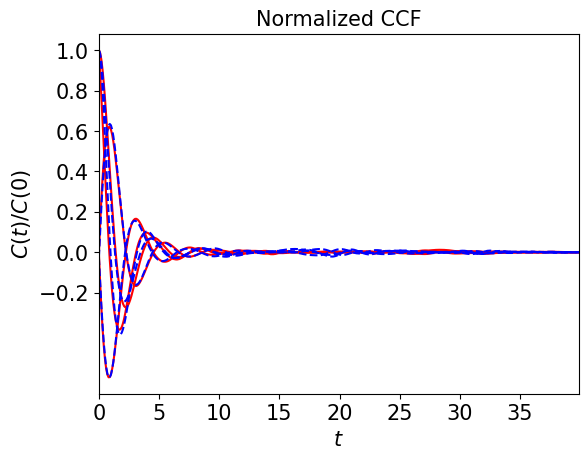

In [62]:
# Test 2: plot the ACF of the sample path generated by the SINN and the exact CCF  

ccf_p=StatLoss.ccf(Pred[-sec_length:,:,:])
ccf_t=StatLoss.ccf(target)
corr_p=ccf_p.detach().cpu().numpy()
corr_t=ccf_t.detach().cpu().numpy()


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized CCF',fontsize=15)    
plt.plot(T, corr_t,'r')        # correlation function of the target 
plt.plot(T, corr_p, 'b--')        # Correlation function after the training      # Correlation function after the training 
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.xlim(0,T[-1])
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

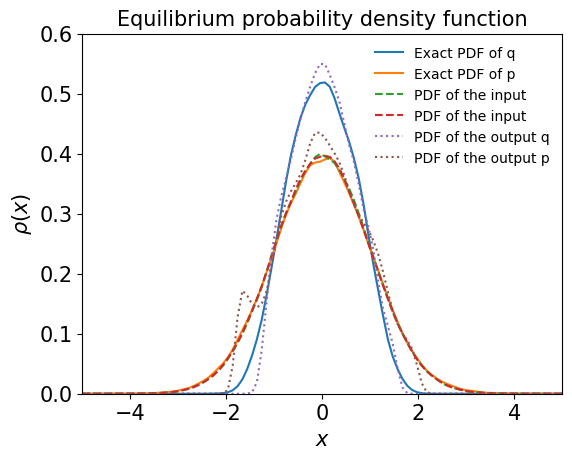

In [63]:
# Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
rho_data =  StatLoss.gauss_kde(target, -5, 5, 100).cpu()
rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100).cpu()
rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100).cpu()


x=np.linspace(-5, 5, 100)
fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r"Equilibrium probability density function",fontsize=15)    
plt.plot(x, rho_data.numpy()[...,0],label=r'Exact PDF of q')    # target PDF
plt.plot(x, rho_data.numpy()[...,1],label=r'Exact PDF of p')    # target PDF
plt.plot(x, rho_input.numpy(), '--', label=r'PDF of the input')     # PDF of the input
plt.plot(x, rho_prediction.numpy()[...,0], ':',label=r'PDF of the output q')  # PDF after the training 
plt.plot(x, rho_prediction.numpy()[...,1], ':',label=r'PDF of the output p')  # PDF after the training 
plt.xlim(-5,5)
plt.ylim(0,0.6)
plt.xlabel(r'$x$',fontsize=15)
plt.ylabel(r'$\rho(x)$',fontsize=15)
plt.legend(frameon=False,fontsize=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

([<matplotlib.axis.YTick at 0x14f0b2749130>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

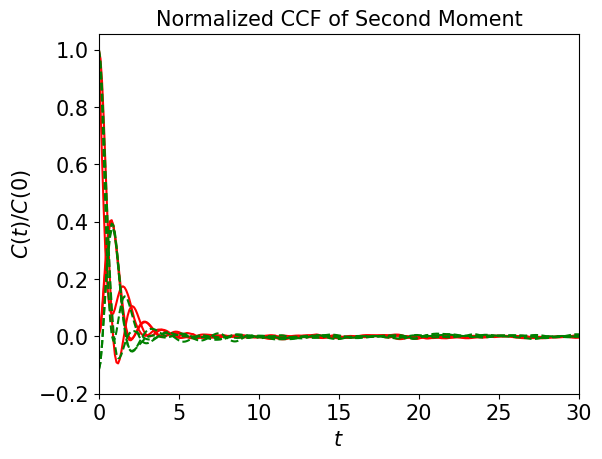

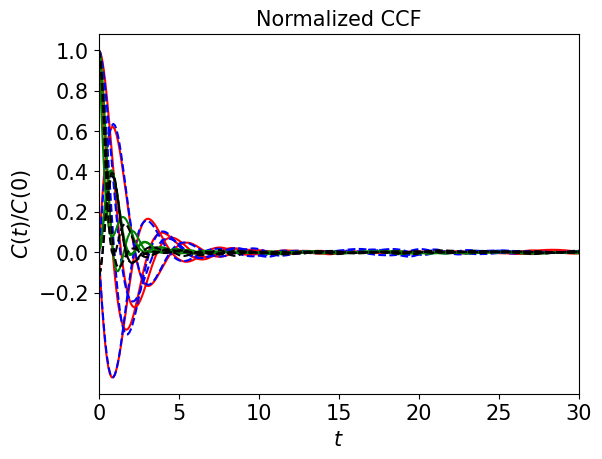

In [64]:
# Test 4: Comparing the higher-order CCF
ccf2=StatLoss.ccf(target**2)
pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,2))
ccf2_app=StatLoss.ccf(pred_norm**2)

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized CCF of Second Moment',fontsize=15)    
plt.plot(T, ccf2.detach().cpu().numpy(),'r',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
plt.plot(T, ccf2_app.detach().cpu().numpy(), 'g--',label=r'Correlation of the output')        # Correlation function after the training 

plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
# plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/FPU_acf2.pdf", dpi=150)


fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized CCF',fontsize=15)  
plt.plot(T, corr_t,'r',label=r'Exact correlation of $q(t)$')        # correlation function of the target 
plt.plot(T, corr_p, 'b--',label=r'Correlation of the output')   
# plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'g',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
# plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'k--',label=r'Correlation of the output')        # Correlation function after the training 
plt.plot(T, ccf2.detach().cpu().numpy(),'g',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
plt.plot(T, ccf2_app.detach().cpu().numpy(), 'k--',label=r'Correlation of the output')        # Correlation function after the training 
plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
# plt.legend(frameon=False,fontsize=10)

(array([  0., 100., 200., 300., 400., 500.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

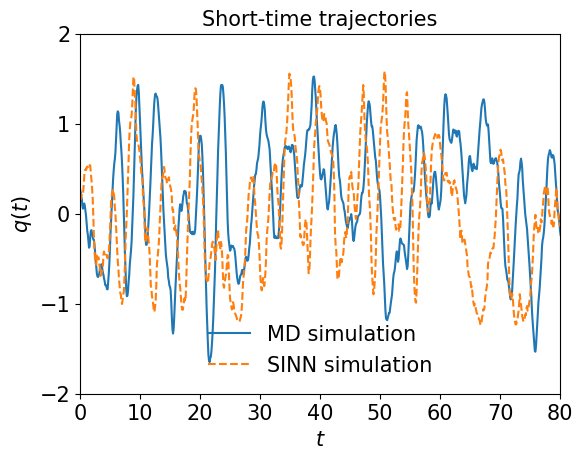

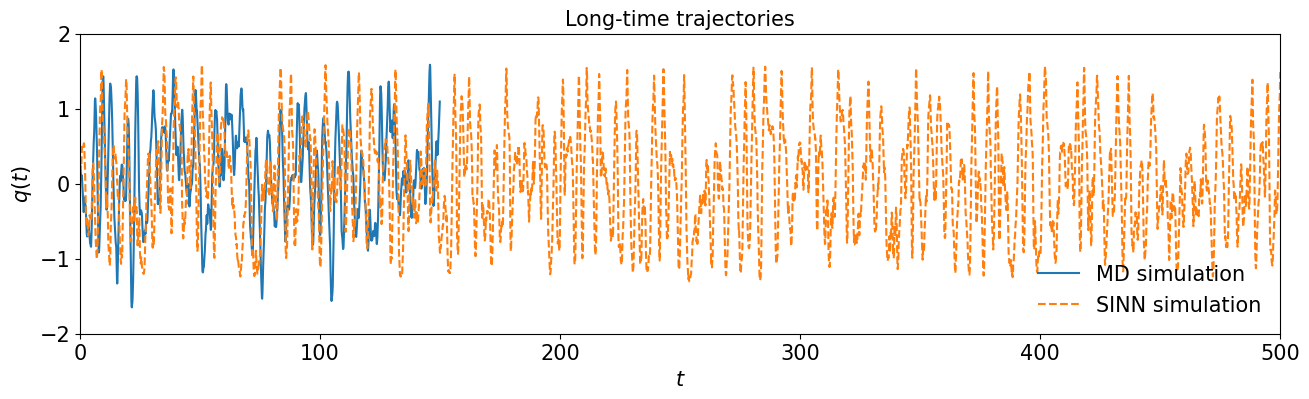

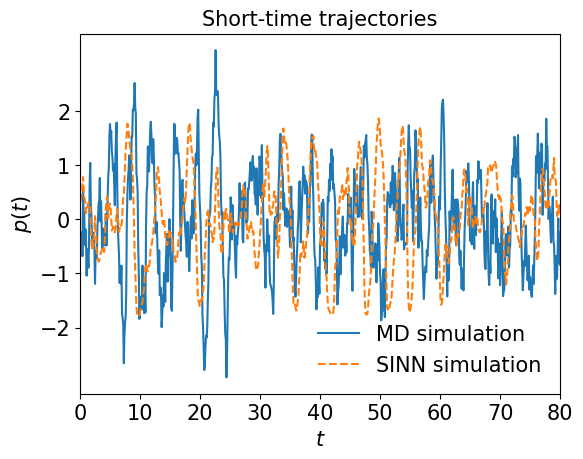

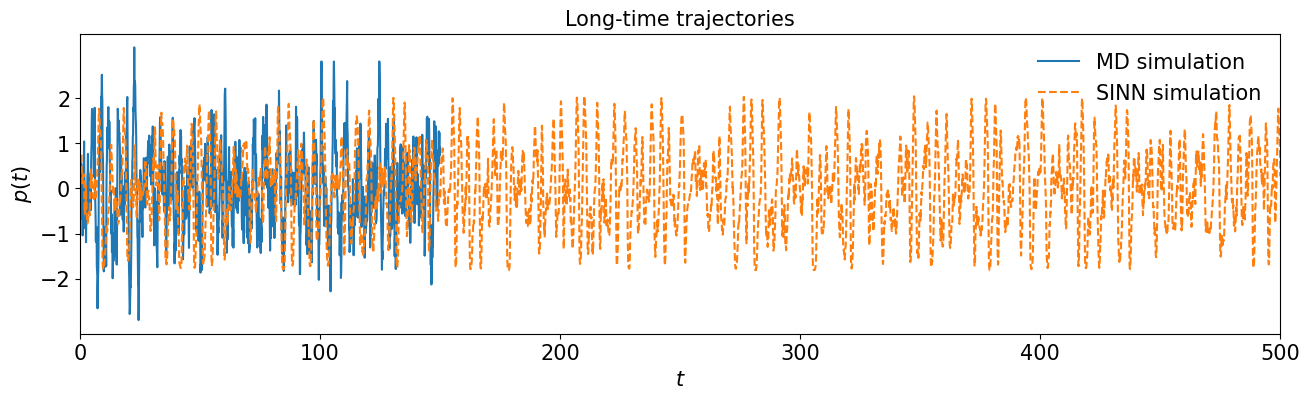

In [66]:
# Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 
[a,b,c]=input.size()
skip=20
scale=10
burnin=3
fold=800
batch_new=50
ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
Pred_L, _= net(ran_input)
prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new,2)
ccf_p=StatLoss.ccf(Pred_L,method='bruteforce')

LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
LT=LT[0:-1]


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Short-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q1_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
plt.xlim([0,80])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/FPU_traj_sT.pdf", dpi=150)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Long-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q1_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
plt.xlim([0,500])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)

fig = plt.figure(2)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Short-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],p1_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
plt.xlim([0,80])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/FPU_traj_sT.pdf", dpi=150)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Long-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],p1_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
plt.xlim([0,500])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)

## 2.3. Loss function=CCF($\textbf{x}$)+PDF($\textbf{x}$)+ACF($\textbf{x}^2$)

In [67]:
### Defining SINN model
net = SINN(2, 5, 2, 2).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [68]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,2*batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,2)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_ccf_fft(prediction) + loss_pdf_empirical(prediction) + loss_acf_sec_moment(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical(pred_val) + loss_acf_sec_moment(pred_val**2)
            loss_val_acf = loss_acf_bruteforce(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.001 and loss_val<=0.001:
            break
print('Training finished')

[0]-th step loss: 0.269, 0.268
[50]-th step loss: 0.251, 0.250
[100]-th step loss: 0.159, 0.156
[150]-th step loss: 0.044, 0.042
[200]-th step loss: 0.018, 0.018
[250]-th step loss: 0.011, 0.010
[300]-th step loss: 0.007, 0.007
[350]-th step loss: 0.006, 0.006
[400]-th step loss: 0.005, 0.005
[450]-th step loss: 0.005, 0.005
[500]-th step loss: 0.004, 0.004
[550]-th step loss: 0.004, 0.004
[600]-th step loss: 0.003, 0.003
[650]-th step loss: 0.003, 0.003
[700]-th step loss: 0.003, 0.003
[750]-th step loss: 0.002, 0.002
[800]-th step loss: 0.002, 0.002
[850]-th step loss: 0.002, 0.002
[900]-th step loss: 0.002, 0.002
[950]-th step loss: 0.002, 0.002
[1000]-th step loss: 0.001, 0.001
[1050]-th step loss: 0.001, 0.001
[1100]-th step loss: 0.001, 0.001
[1150]-th step loss: 0.001, 0.001
Training finished
CPU times: user 54.2 s, sys: 82.6 ms, total: 54.2 s
Wall time: 54.3 s


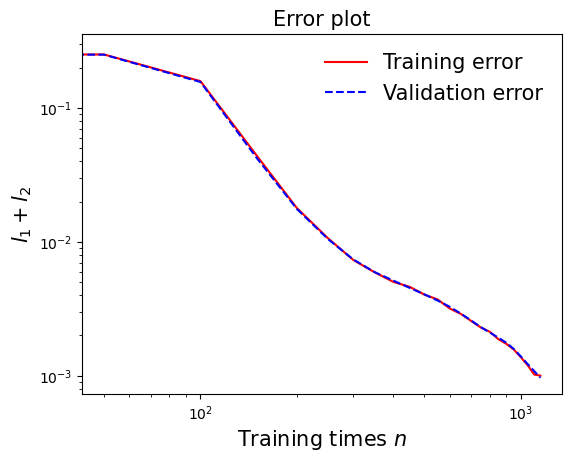

In [69]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [70]:
# # Gaussian random input
ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
Pred,_= net(ran_input)
prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)

([<matplotlib.axis.YTick at 0x14f10a1ced90>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

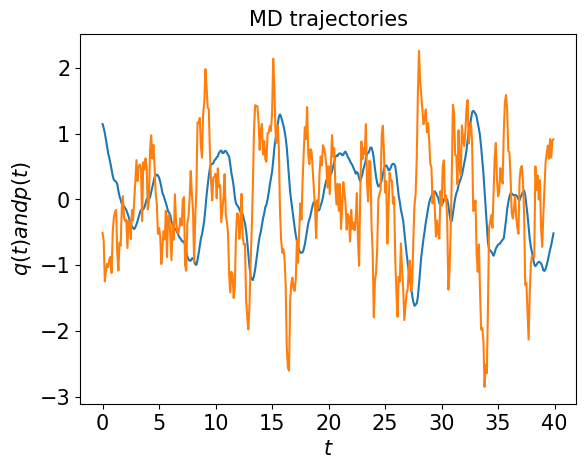

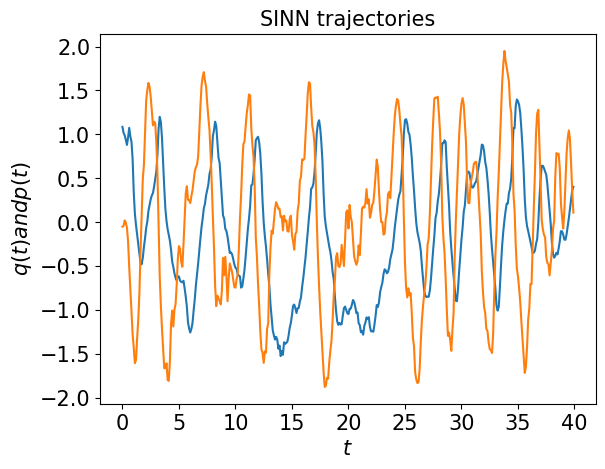

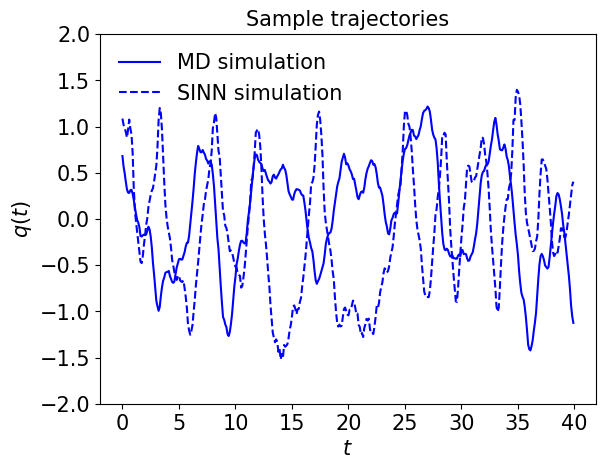

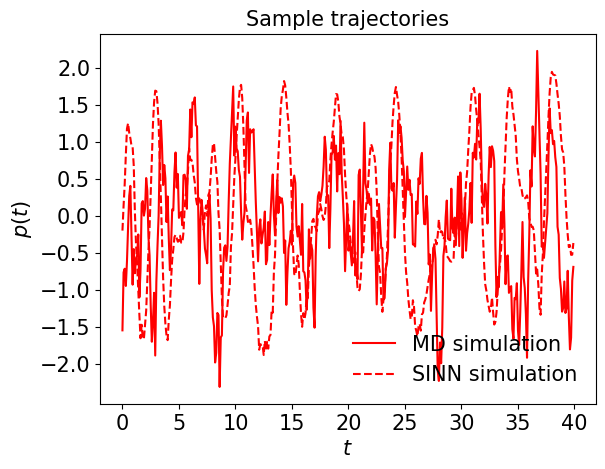

In [71]:
# Test 1: plot the sample path generated by SINN and the exact sample path 
skip = 0

fig = plt.figure(0)
plt.title("MD trajectories",fontsize=15) 
plt.plot(T[skip:]-T[skip], Traj[skip:, 6])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t) and p(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.ylim((-6,4))
# plt.savefig("figs/FPU_traj_multi_MD.pdf", dpi=150)

fig = plt.figure(1)
plt.title("SINN trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], prediction[skip:, 5])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t) and p(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.ylim((-6,4))
# plt.savefig("figs/FPU_traj_multi.pdf", dpi=150)


fig = plt.figure(2)
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 4, 0], 'b',label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 5, 0],'b--',label='SINN simulation')
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)

fig = plt.figure(3)
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 4, 1],'r', label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 7, 1],'r--',label='SINN simulation')
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)

([<matplotlib.axis.YTick at 0x14f10a0705b0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

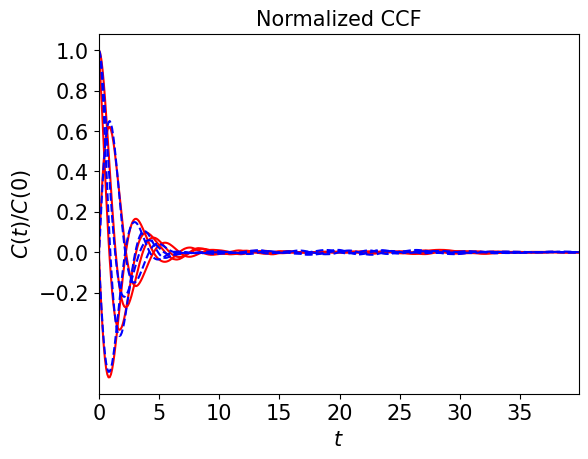

In [72]:
# Test 2: plot the ACF of the sample path generated by the SINN and the exact ACF  

ccf_p=StatLoss.ccf(Pred[-sec_length:,:,:])
ccf_t=StatLoss.ccf(target)
corr_p=ccf_p.detach().cpu().numpy()
corr_t=ccf_t.detach().cpu().numpy()


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized CCF',fontsize=15)    
plt.plot(T, corr_t,'r')        # correlation function of the target 
plt.plot(T, corr_p, 'b--')        # Correlation function after the training      # Correlation function after the training 
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.xlim(0,T[-1])
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

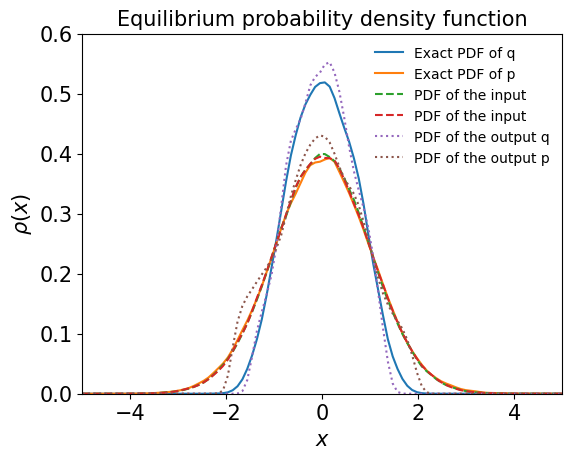

In [73]:
# Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
rho_data =  StatLoss.gauss_kde(target, -5, 5, 100).cpu()
rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100).cpu()
rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100).cpu()


x=np.linspace(-5, 5, 100)
fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r"Equilibrium probability density function",fontsize=15)    
plt.plot(x, rho_data.numpy()[...,0],label=r'Exact PDF of q')    # target PDF
plt.plot(x, rho_data.numpy()[...,1],label=r'Exact PDF of p')    # target PDF
plt.plot(x, rho_input.numpy(), '--', label=r'PDF of the input')     # PDF of the input
plt.plot(x, rho_prediction.numpy()[...,0], ':',label=r'PDF of the output q')  # PDF after the training 
plt.plot(x, rho_prediction.numpy()[...,1], ':',label=r'PDF of the output p')  # PDF after the training 
plt.xlim(-5,5)
plt.ylim(0,0.6)
plt.xlabel(r'$x$',fontsize=15)
plt.ylabel(r'$\rho(x)$',fontsize=15)
plt.legend(frameon=False,fontsize=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

([<matplotlib.axis.YTick at 0x14f10a02c8b0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

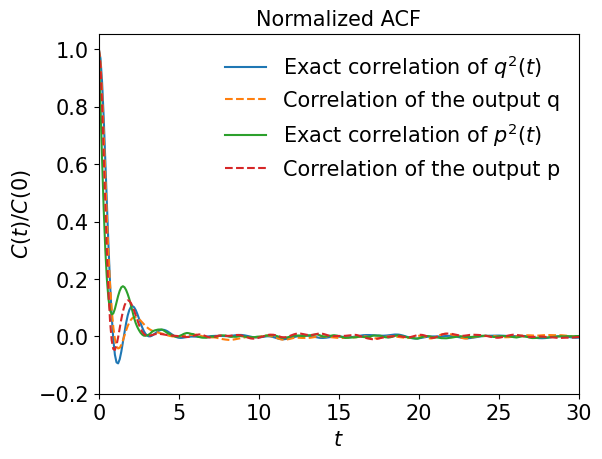

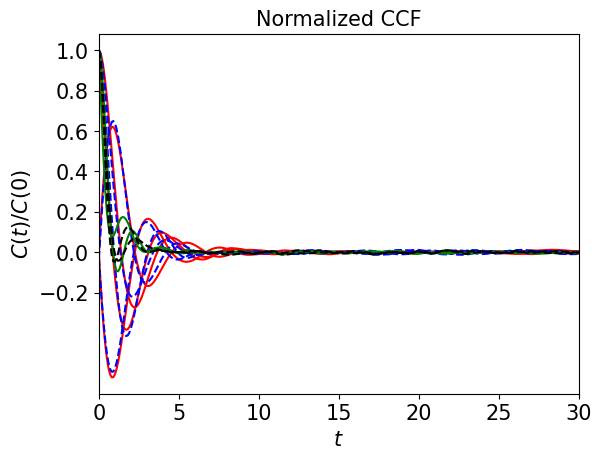

In [74]:
# Test 4: Comparing the higher-order ACF
acf2=StatLoss.acf(target**2)
pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,2))
acf2_app=StatLoss.acf(pred_norm**2)

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, acf2.detach().cpu().numpy()[...,0],'',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.detach().cpu().numpy()[...,0], '--',label=r'Correlation of the output q')        # Correlation function after the training 
plt.plot(T, acf2.detach().cpu().numpy()[...,1],'',label=r'Exact correlation of $p^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.detach().cpu().numpy()[...,1], '--',label=r'Correlation of the output p')        # Correlation function after the training 

plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/FPU_acf2.pdf", dpi=150)


fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized CCF',fontsize=15)  
plt.plot(T, corr_t,'r',label=r'Exact correlation of $q(t)$')        # correlation function of the target 
plt.plot(T, corr_p, 'b--',label=r'Correlation of the output')   
# plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'g',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
# plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'k--',label=r'Correlation of the output')        # Correlation function after the training 
plt.plot(T, acf2.detach().cpu().numpy(),'g',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.detach().cpu().numpy(), 'k--',label=r'Correlation of the output')        # Correlation function after the training 
plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)

(array([  0., 100., 200., 300., 400., 500.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

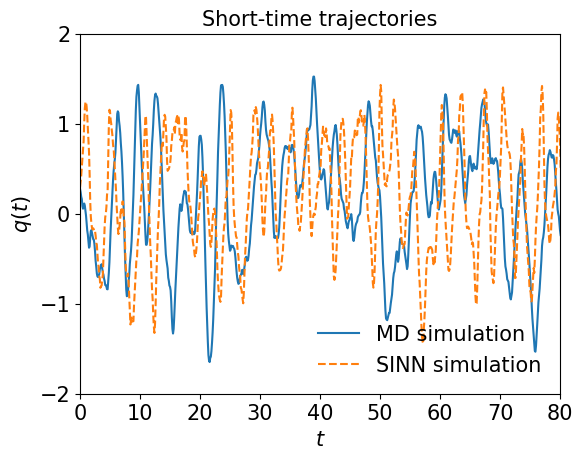

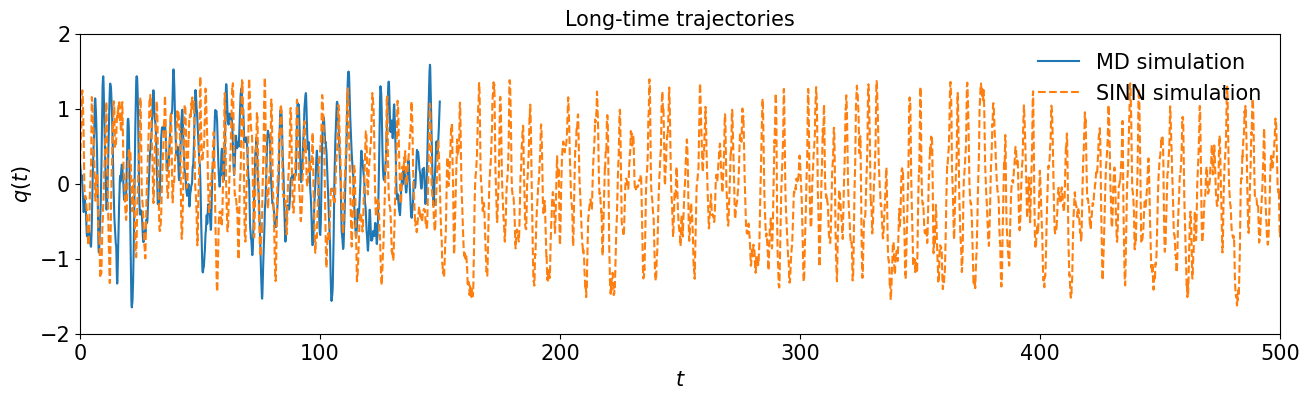

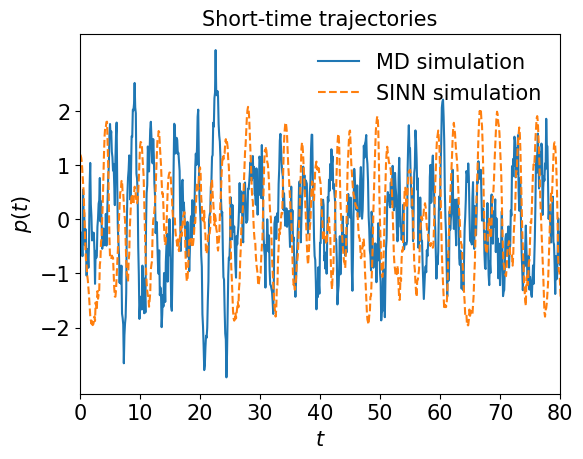

In [ ]:
# Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 
[a,b,c]=input.size()
skip=20
scale=10
burnin=3
fold=800
batch_new=50
ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
Pred_L, _= net(ran_input)
prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new,2)
ccf_p=StatLoss.ccf(Pred_L,method='bruteforce')

LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
LT=LT[0:-1]


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Short-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q1_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
plt.xlim([0,80])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/FPU_traj_sT.pdf", dpi=150)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Long-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q1_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
plt.xlim([0,500])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)

fig = plt.figure(2)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Short-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],p1_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
plt.xlim([0,80])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/FPU_traj_sT.pdf", dpi=150)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Long-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],p1_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
plt.xlim([0,500])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)